Reference:

Gu, Gao-Feng Gu, and Wei-Xing Zhou. "Detrending moving average algorithm for multifractals." Physical Review E, no. 82, 2010, pp. 011136,

Arianos, Sergio, and Anna Carbone. "Detrending moving average algorithm: A closed-form approximation of the scaling law." Physica A, no. 382, 2007, pp. 9–15,

Wang, Yudong, et al. “Multifractal Detrending Moving Average Analysis on The US Dollar Exchange Rates.” Physica A, no. 390, 2011, pp. 3512–3523.

In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import pandas_market_calendars as mcal
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import tensorflow as tf

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential

In [2]:
plt.style.use('seaborn-darkgrid')

In [6]:
files = 'https://raw.githubusercontent.com/y3kiys4/wqu_capstone_june2023_grp3626/main/SPX_1m_Dec2020_Jun2023.csv'
df0 = pd.read_csv(files)
df0

,Time,Price
0,12/1/2020 0:00,3653.339
1,12/1/2020 0:01,3654.045
2,12/1/2020 0:02,3654.336
3,12/1/2020 0:03,3653.945
4,12/1/2020 0:04,3653.845
...,...,...
836793,6/30/2023 16:09,4446.311
836794,6/30/2023 16:10,4445.570
836795,6/30/2023 16:11,4445.332
836796,6/30/2023 16:12,4445.320


Split dadasets by daylight savings time (Nov. 6, 2022)

In [7]:
# Locate the beginning data of in 2021
df0[df0['Time']=='1/3/2021 18:15'].index

Index([27777], dtype='int64')

In [8]:
# Locate the beginning data of Daylight Savings time in 2021
df0[df0['Time']=='3/14/2021 17:00'].index

Index([93383], dtype='int64')

In [9]:
# Locate the beginning data of standard time in 2021
df0[df0['Time']=='11/7/2021 18:00'].index

Index([310612], dtype='int64')

In [10]:
# Locate the beginning data of Daylight Savings time in 2022
df0[df0['Time']=='3/13/2022 17:00'].index

Index([427563], dtype='int64')

In [11]:
# Locate the beginning data of standard time in 2022
df0[df0['Time']=='11/6/2022 18:00'].index

Index([651549], dtype='int64')

In [12]:
# Locate the beginning data of Daylight Savings time in 2023
df0[df0['Time']=='3/12/2023 17:00'].index

Index([762000], dtype='int64')

In [13]:
# Select data in the standard time in first half of 2021
df1 = df0[27777:93383]

# Set timestamp as index
df1 = df1.set_index(df1['Time'])
df1.drop(['Time'], axis=1, inplace=True)
df1.index = pd.to_datetime(df1.index)

# Adjust dataset timestamp, GMT 23:59:00 --> 15:14:00 of Chicago local time
df1.index = df1.index + pd.DateOffset(hours=3, minutes=45)
df1

,Price
Time,
2021-01-03 22:00:00,3757.951
2021-01-03 22:01:00,3758.251
2021-01-03 22:02:00,3758.133
2021-01-03 22:03:00,3757.933
2021-01-03 22:04:00,3757.736
...,...
2021-03-12 19:55:00,3945.645
2021-03-12 19:56:00,3944.651
2021-03-12 19:57:00,3944.945


In [14]:
# Select data in the Daylight Savings time in 2021
df2 = df0[93383:310612]

# Set timestamp as index
df2 = df2.set_index(df2['Time'])
df2.drop(['Time'], axis=1, inplace=True)
df2.index = pd.to_datetime(df2.index)

# Adjust dataset timestamp, GMT 23:59:00 --> 15:14:00 of Chicago local time
df2.index = df2.index + pd.DateOffset(hours=2, minutes=45)
df2

,Price
Time,
2021-03-14 19:45:00,3948.736
2021-03-14 19:46:00,3951.439
2021-03-14 19:47:00,3951.845
2021-03-14 19:48:00,3951.851
2021-03-14 19:49:00,3951.739
...,...
2021-11-05 17:55:00,4693.351
2021-11-05 17:56:00,4693.039
2021-11-05 17:57:00,4692.399


In [15]:
# Select data in the standard time in second half of 2021 and first half of 2022
df3 = df0[310612:427563]

# Set timestamp as index
df3 = df3.set_index(df3['Time'])
df3.drop(['Time'], axis=1, inplace=True)
df3.index = pd.to_datetime(df3.index)

# Adjust dataset timestamp, GMT 23:59:00 --> 15:14:00 of Chicago local time
df3.index = df3.index + pd.DateOffset(hours=3, minutes=45)
df3

,Price
Time,
2021-11-07 21:45:00,4693.239
2021-11-07 21:46:00,4690.842
2021-11-07 21:47:00,4691.848
2021-11-07 21:48:00,4692.899
2021-11-07 21:49:00,4692.539
...,...
2022-03-11 19:55:00,4206.039
2022-03-11 19:56:00,4206.439
2022-03-11 19:57:00,4206.351


In [16]:
# Select data in the Daylight Savings time in 2022
df4 = df0[427563:651549]

# Set timestamp as index
df4 = df4.set_index(df4['Time'])
df4.drop(['Time'], axis=1, inplace=True)
df4.index = pd.to_datetime(df4.index)

# Adjust dataset timestamp, GMT 23:59:00 --> 15:14:00 of Chicago local time
df4.index = df4.index + pd.DateOffset(hours=2, minutes=45)
df4

,Price
Time,
2022-03-13 19:45:00,4215.554
2022-03-13 19:46:00,4217.539
2022-03-13 19:47:00,4223.133
2022-03-13 19:48:00,4224.651
2022-03-13 19:49:00,4226.536
...,...
2022-11-04 17:55:00,3770.569
2022-11-04 17:56:00,3770.572
2022-11-04 17:57:00,3770.316


In [17]:
# Select data in the standard time in second half of 2022 and first half of 2023
df5 = df0[651549:762000]

# Set timestamp as index
df5 = df5.set_index(df5['Time'])
df5.drop(['Time'], axis=1, inplace=True)
df5.index = pd.to_datetime(df5.index)

# Adjust dataset timestamp, GMT 23:59:00 --> 15:14:00 of Chicago local time
df5.index = df5.index + pd.DateOffset(hours=3, minutes=45)
df5

,Price
Time,
2022-11-06 21:45:00,3740.480
2022-11-06 21:46:00,3744.239
2022-11-06 21:47:00,3741.613
2022-11-06 21:48:00,3743.619
2022-11-06 21:49:00,3744.480
...,...
2023-03-10 19:40:00,3857.111
2023-03-10 19:41:00,3856.350
2023-03-10 19:42:00,3862.082


In [18]:
# Select data in the Daylight Savings time in 2022
df6 = df0[762000:]

# Set timestamp as index
df6 = df6.set_index(df6['Time'])
df6.drop(['Time'], axis=1, inplace=True)
df6.index = pd.to_datetime(df6.index)

# Adjust dataset timestamp, GMT 23:59:00 --> 15:14:00 of Chicago local time
df6.index = df6.index + pd.DateOffset(hours=2, minutes=45)
df6

,Price
Time,
2023-03-12 19:45:00,3877.967
2023-03-12 19:46:00,3870.914
2023-03-12 19:47:00,3876.290
2023-03-12 19:48:00,3877.597
2023-03-12 19:49:00,3870.182
...,...
2023-06-30 18:54:00,4446.311
2023-06-30 18:55:00,4445.570
2023-06-30 18:56:00,4445.332


In [19]:
# Concatenate the two datasets
df = pd.DataFrame(pd.concat([df1, df2, df3, df4, df5, df6]))
df

,Price
Time,
2021-01-03 22:00:00,3757.951
2021-01-03 22:01:00,3758.251
2021-01-03 22:02:00,3758.133
2021-01-03 22:03:00,3757.933
2021-01-03 22:04:00,3757.736
...,...
2023-06-30 18:54:00,4446.311
2023-06-30 18:55:00,4445.570
2023-06-30 18:56:00,4445.332


In [20]:
# Calculate log return
df['log_ret'] = np.log(df['Price'].astype(float)).diff() * 10000 # 10,000 times log return

# Calculate the time difference in mininutes
df['deltaT'] = (df.index.to_series().diff().dt.days.mul(60*24, fill_value=0) +
                df.index.to_series().diff().dt.seconds.div(60, fill_value=0)
               )
df['missingT'] = df['deltaT'] - 1

df_1min = df[df['deltaT'] == 1]
df_1min['log_ret_sq'] = np.square(df_1min['log_ret'])
df_1min

C:\Users\cutef\AppData\Local\Temp\ipykernel_11196\3242030435.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1min['log_ret_sq'] = np.square(df_1min['log_ret'])


,Price,log_ret,deltaT,missingT,log_ret_sq
Time,,,,,
2021-01-03 22:01:00,3758.251,0.798276,1.0,0.0,0.637244
2021-01-03 22:02:00,3758.133,-0.313981,1.0,0.0,0.098584
2021-01-03 22:03:00,3757.933,-0.532193,1.0,0.0,0.283230
2021-01-03 22:04:00,3757.736,-0.524238,1.0,0.0,0.274826
2021-01-03 22:05:00,3758.233,1.322517,1.0,0.0,1.749052
...,...,...,...,...,...
2023-06-30 18:54:00,4446.311,-1.171689,1.0,0.0,1.372856
2023-06-30 18:55:00,4445.570,-1.666689,1.0,0.0,2.777852
2023-06-30 18:56:00,4445.332,-0.535379,1.0,0.0,0.286630


In [21]:
# Count total days
f_date = dt.date(2021, 1, 4)
l_date = dt.date(2023, 6, 30)
len_calendar_days = (l_date - f_date).days
len_calendar_days

907

In [22]:
# Count the index trading days
cboe = mcal.get_calendar('CBOE_Index_Options')
trading_days = cboe.schedule(start_date='2021-01-04', end_date='2023-06-30')
len_trading_days = len(trading_days)
len_trading_days

650

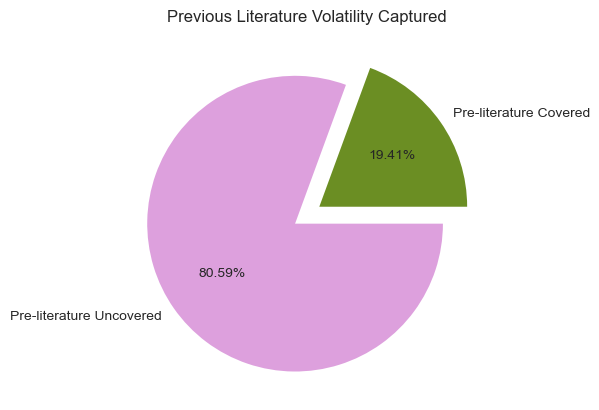

In [23]:
# Other researchers' data usage ratio
covered_pre_literature = (len_trading_days * 60 * 6.5) / (len_calendar_days * 60 * 24)
uncovered_pre_literature = 1 - covered_pre_literature

# Visualize
labels = 'Pre-literature Covered', 'Pre-literature Uncovered'
sizes = [covered_pre_literature, uncovered_pre_literature]
explode = (0.1, 0.1)
colors=['olivedrab', 'plum']

fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%',
        colors=colors, shadow=False, startangle=0)
plt.title('Previous Literature Volatility Captured')
plt.savefig('Previous Literature Volatility Captured.png')
plt.show()

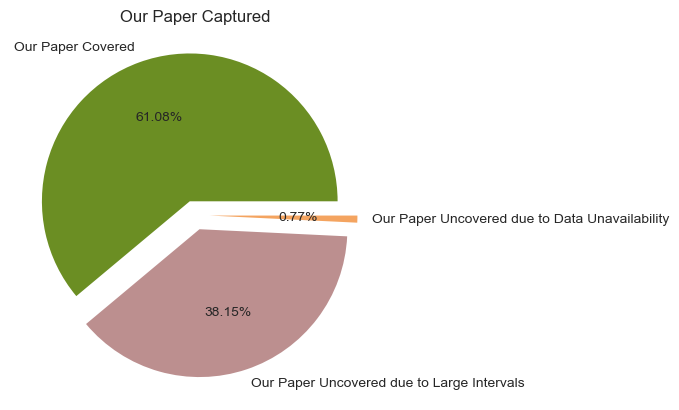

In [24]:
# Our paper data usage ratio
covered_our_paper = len(df_1min) / (len_calendar_days * 60 * 24)
uncovered_our_paper_large_interval = df['missingT'].sum() / (len_calendar_days * 60 * 24)
uncovered_data_unavailable = 1 - covered_our_paper - uncovered_our_paper_large_interval

# Visualize
labels = 'Our Paper Covered', 'Our Paper Uncovered due to Large Intervals', 'Our Paper Uncovered due to Data Unavailability'
sizes = [covered_our_paper, uncovered_our_paper_large_interval, uncovered_data_unavailable]
explode = (0.1, 0.1, 0.1)
colors = ['olivedrab', 'rosybrown', 'sandybrown']

fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%',
        colors=colors, shadow=False, startangle=0)
plt.title('Our Paper Captured')
plt.savefig('Our Paper Captured.png')
plt.show()

In [25]:
# Change the setting to show 1000 rows
pd.set_option('display.max_rows', 1000)

## Slice dataset into daily, weekly and monthly segments

### Determine how many data points in a day on average

In [26]:
available_daily = df_1min['deltaT'].resample('1d').count().to_frame()
available_daily['day_of_week'] = available_daily.index.dayofweek
print(available_daily)

            deltaT  day_of_week
Time                           
2021-01-03     119            6
2021-01-04    1304            0
2021-01-05    1327            1
2021-01-06    1332            2
2021-01-07    1334            3
2021-01-08    1198            4
2021-01-09       0            5
2021-01-10     134            6
2021-01-11    1332            0
2021-01-12    1318            1
2021-01-13    1263            2
2021-01-14    1296            3
2021-01-15    1200            4
2021-01-16       0            5
2021-01-17     134            6
2021-01-18    1044            0
2021-01-19    1295            1
2021-01-20    1298            2
2021-01-21    1274            3
2021-01-22    1183            4
2021-01-23       0            5
2021-01-24     134            6
2021-01-25    1285            0
2021-01-26    1326            1
2021-01-27    1324            2
2021-01-28    1334            3
2021-01-29    1200            4
2021-01-30       0            5
2021-01-31     134            6
2021-02-

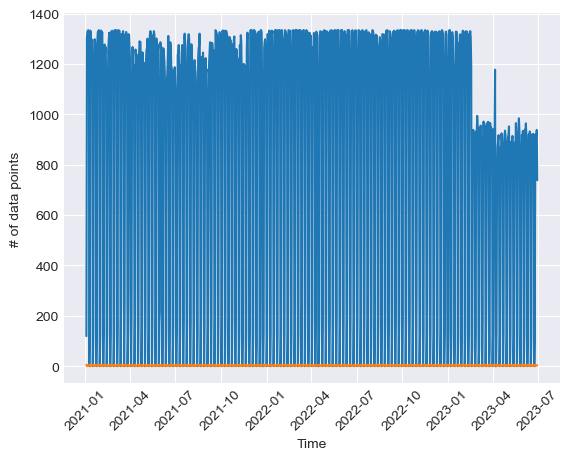

In [27]:
plt.plot(available_daily)
plt.xlabel('Time')
plt.ylabel('# of data points')
plt.savefig('Available Daily.png')
plt.xticks(rotation=45)
plt.show()

Daily data points since Feb 18, 2023 decreased sharply, we cut the data points since then

In [28]:
# Locate the beginning data of less trading hours
df0[df0['Time']=='2/19/2023 19:00'].index

Index([747793], dtype='int64')

In [29]:
# Select data in the standard time in second half of 2022 and first half of 2023
df7 = df0[651549:747793]

# Set timestamp as index
df7 = df7.set_index(df7['Time'])
df7.drop(['Time'], axis=1, inplace=True)
df7.index = pd.to_datetime(df7.index)

# Adjust dataset timestamp, GMT 23:59:00 --> 15:14:00 of Chicago local time
df7.index = df7.index + pd.DateOffset(hours=3, minutes=45)
df7

,Price
Time,
2022-11-06 21:45:00,3740.480
2022-11-06 21:46:00,3744.239
2022-11-06 21:47:00,3741.613
2022-11-06 21:48:00,3743.619
2022-11-06 21:49:00,3744.480
...,...
2023-02-17 19:55:00,4077.163
2023-02-17 19:56:00,4076.663
2023-02-17 19:57:00,4077.163


In [30]:
# Concatenate the two datasets
df = pd.DataFrame(pd.concat([df1, df2, df3, df4, df7]))
df

,Price
Time,
2021-01-03 22:00:00,3757.951
2021-01-03 22:01:00,3758.251
2021-01-03 22:02:00,3758.133
2021-01-03 22:03:00,3757.933
2021-01-03 22:04:00,3757.736
...,...
2023-02-17 19:55:00,4077.163
2023-02-17 19:56:00,4076.663
2023-02-17 19:57:00,4077.163


In [31]:
# Calculate log return
df['log_ret'] = np.log(df['Price'].astype(float)).diff() * 10000 # 10,000 times log return

# Calculate the time difference in mininutes
df['deltaT'] = (df.index.to_series().diff().dt.days.mul(60*24, fill_value=0) +
                df.index.to_series().diff().dt.seconds.div(60, fill_value=0)
               )
df['missingT'] = df['deltaT'] - 1

df_1min = df[df['deltaT'] == 1]
df_1min['log_ret_sq'] = np.square(df_1min['log_ret'])
df_1min

C:\Users\cutef\AppData\Local\Temp\ipykernel_11196\3242030435.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1min['log_ret_sq'] = np.square(df_1min['log_ret'])


,Price,log_ret,deltaT,missingT,log_ret_sq
Time,,,,,
2021-01-03 22:01:00,3758.251,0.798276,1.0,0.0,0.637244
2021-01-03 22:02:00,3758.133,-0.313981,1.0,0.0,0.098584
2021-01-03 22:03:00,3757.933,-0.532193,1.0,0.0,0.283230
2021-01-03 22:04:00,3757.736,-0.524238,1.0,0.0,0.274826
2021-01-03 22:05:00,3758.233,1.322517,1.0,0.0,1.749052
...,...,...,...,...,...
2023-02-17 19:55:00,4077.163,-1.233625,1.0,0.0,1.521830
2023-02-17 19:56:00,4076.663,-1.226418,1.0,0.0,1.504101
2023-02-17 19:57:00,4077.163,1.226418,1.0,0.0,1.504101


In [32]:
# Count total days
f_date = dt.date(2021, 1, 4)
l_date = dt.date(2023, 2, 17)
len_calendar_days = (l_date - f_date).days
len_calendar_days

774

In [33]:
# Count the index trading days
cboe = mcal.get_calendar('CBOE_Index_Options')
trading_days = cboe.schedule(start_date='2021-01-04', end_date='2023-02-17')
len_trading_days = len(trading_days)
len_trading_days

555

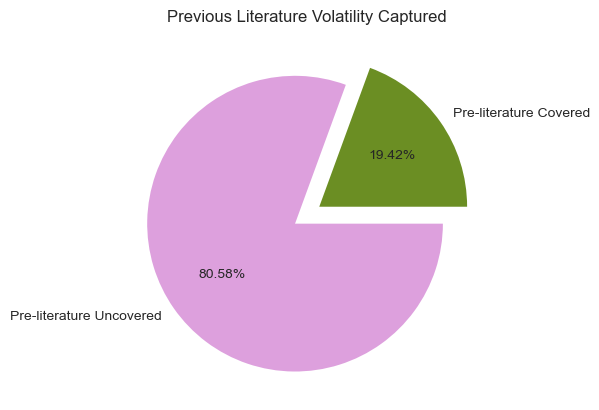

In [34]:
# Other researchers' data usage ratio
covered_pre_literature = (len_trading_days * 60 * 6.5) / (len_calendar_days * 60 * 24)
uncovered_pre_literature = 1 - covered_pre_literature

# Visualize
labels = 'Pre-literature Covered', 'Pre-literature Uncovered'
sizes = [covered_pre_literature, uncovered_pre_literature]
explode = (0.1, 0.1)
colors=['olivedrab', 'plum']

fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%',
        colors=colors, shadow=False, startangle=0)
plt.title('Previous Literature Volatility Captured')
plt.savefig('Previous Literature Volatility Captured.png')
plt.show()

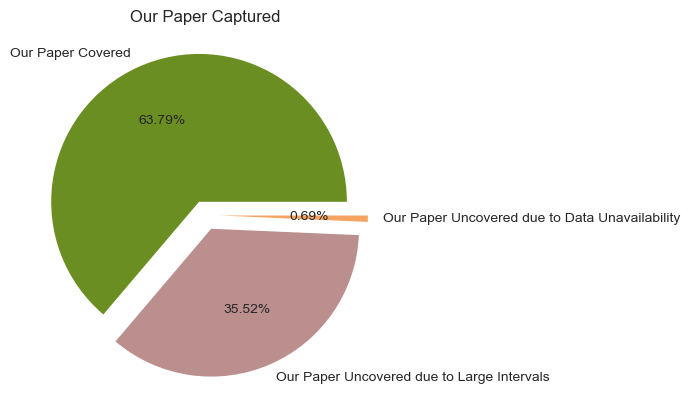

In [35]:
# Our paper data usage ratio
covered_our_paper = len(df_1min) / (len_calendar_days * 60 * 24)
uncovered_our_paper_large_interval = df['missingT'].sum() / (len_calendar_days * 60 * 24)
uncovered_data_unavailable = 1 - covered_our_paper - uncovered_our_paper_large_interval

# Visualize
labels = 'Our Paper Covered', 'Our Paper Uncovered due to Large Intervals', 'Our Paper Uncovered due to Data Unavailability'
sizes = [covered_our_paper, uncovered_our_paper_large_interval, uncovered_data_unavailable]
explode = (0.1, 0.1, 0.1)
colors = ['olivedrab', 'rosybrown', 'sandybrown']

fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%',
        colors=colors, shadow=False, startangle=0)
plt.title('Our Paper Captured')
plt.savefig('Our Paper Captured.png')
plt.show()

In [36]:
available_daily = df_1min['deltaT'].resample('1d').count().to_frame()
available_daily['day_of_week'] = available_daily.index.dayofweek
print(available_daily)

            deltaT  day_of_week
Time                           
2021-01-03     119            6
2021-01-04    1304            0
2021-01-05    1327            1
2021-01-06    1332            2
2021-01-07    1334            3
2021-01-08    1198            4
2021-01-09       0            5
2021-01-10     134            6
2021-01-11    1332            0
2021-01-12    1318            1
2021-01-13    1263            2
2021-01-14    1296            3
2021-01-15    1200            4
2021-01-16       0            5
2021-01-17     134            6
2021-01-18    1044            0
2021-01-19    1295            1
2021-01-20    1298            2
2021-01-21    1274            3
2021-01-22    1183            4
2021-01-23       0            5
2021-01-24     134            6
2021-01-25    1285            0
2021-01-26    1326            1
2021-01-27    1324            2
2021-01-28    1334            3
2021-01-29    1200            4
2021-01-30       0            5
2021-01-31     134            6
2021-02-

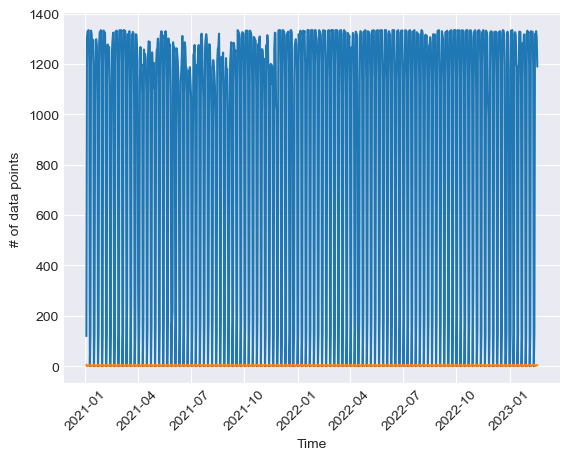

In [37]:
plt.plot(available_daily)
plt.xlabel('Time')
plt.ylabel('# of data points')
plt.savefig('Available Daily.png')
plt.xticks(rotation=45)
plt.show()

In [2]:
# Average daily data availability
avg_daily = int(available_daily['deltaT'].sum() / len_trading_days)
avg_daily

NameError: name 'available_daily' is not defined

### Determine how many data points in a week on average

In [39]:
available_weekly =  df_1min['deltaT'].resample('1w').count().to_frame()

print(available_weekly)

            deltaT
Time              
2021-01-03     119
2021-01-10    6629
2021-01-17    6543
2021-01-24    6228
2021-01-31    6603
2021-02-07    6619
2021-02-14    6318
2021-02-21    6039
2021-02-28    6651
2021-03-07    6650
2021-03-14    6782
2021-03-21    6610
2021-03-28    6474
2021-04-04    5603
2021-04-11    6043
2021-04-18    6183
2021-04-25    6323
2021-05-02    5987
2021-05-09    6269
2021-05-16    6571
2021-05-23    6582
2021-05-30    6337
2021-06-06    5323
2021-06-13    5917
2021-06-20    6109
2021-06-27    6167
2021-07-04    5851
2021-07-11    5924
2021-07-18    6193
2021-07-25    6317
2021-08-01    6497
2021-08-08    6113
2021-08-15    5760
2021-08-22    6397
2021-08-29    6064
2021-09-05    5837
2021-09-12    5730
2021-09-19    6369
2021-09-26    6624
2021-10-03    6603
2021-10-10    6646
2021-10-17    6605
2021-10-24    6486
2021-10-31    6559
2021-11-07    6061
2021-11-14    6386
2021-11-21    5982
2021-11-28    6103
2021-12-05    6661
2021-12-12    6560
2021-12-19  

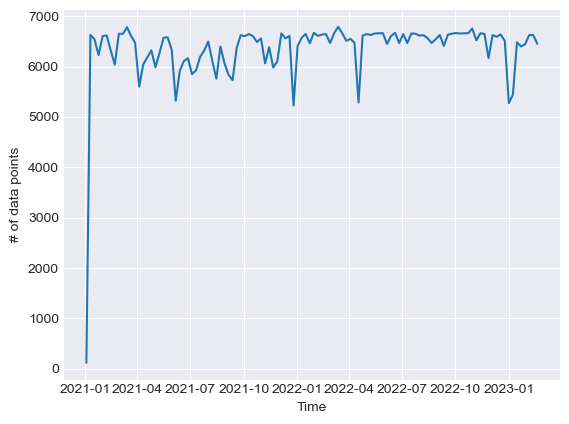

In [40]:
plt.plot(available_weekly)
plt.xlabel('Time')
plt.ylabel('# of data points')
plt.savefig('Available Weekly.png')
plt.show()

#### Method one: drop incomplete week data points

In [41]:
# Drop the incomplete first and last week

available_weekly_drop = available_weekly.loc[available_weekly['deltaT'] != available_weekly['deltaT'].min()]
# available_weekly_drop = available_weekly.loc[available_weekly['deltaT'] != available_weekly['deltaT'].min()]

available_weekly_drop

,deltaT
Time,
2021-01-10,6629
2021-01-17,6543
2021-01-24,6228
2021-01-31,6603
2021-02-07,6619
2021-02-14,6318
2021-02-21,6039
2021-02-28,6651
2021-03-07,6650


In [42]:
avg_weekly1 = int(available_weekly_drop.mean())
avg_weekly1

C:\Users\cutef\AppData\Local\Temp\ipykernel_11196\2082506604.py:1: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  avg_weekly1 = int(available_weekly_drop.mean())


6404

#### Method Two: don't drop incomplete weekly data points

In [43]:
avg_weekly = int(available_weekly.mean())
avg_weekly

C:\Users\cutef\AppData\Local\Temp\ipykernel_11196\2549662872.py:1: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  avg_weekly = int(available_weekly.mean())


6348

### Determine how many data points in a month on average

In [44]:
available_monthly =  df_1min['deltaT'].resample('1m').count().to_frame()
available_monthly

,deltaT
Time,
2021-01-31,26122
2021-02-28,25627
2021-03-31,30418
2021-04-30,26070
2021-05-31,26144
2021-06-30,26820
2021-07-31,27079
2021-08-31,26830
2021-09-30,27514


In [45]:
avg_monthly = available_monthly['deltaT'][:-2].mean() # Discard Feb 2023 because of data incompleteness
avg_monthly

27773.041666666668

### Determine conversion ratio between daily, weekly and monthly

In [46]:
ratio_weekly = int(round(avg_weekly / avg_daily, 0))
ratio_monthly = int(round(avg_monthly / avg_daily, 0))

print(f'Conversion ratio of weekly and monthly to daily are {ratio_weekly} and {ratio_monthly}, respectively')

Conversion ratio of weekly and monthly to daily are 5 and 22, respectively


In [47]:
modified_weekly_data = int(ratio_weekly * avg_daily)
modified_monthly_data = int(ratio_monthly * avg_daily)

print(f'We use {avg_daily}, {modified_weekly_data} \
and {modified_monthly_data} data points, respectively for daily, weekly and monthly available dataset')

We use 1281, 6405 and 28182 data points, respectively for daily, weekly and monthly available dataset


In [3]:
avg_daily = int(1281)
modified_weekly_data = int(6405)
modified_monthly_data = int(28182)

In [4]:
# Change the setting to show 200 rows
pd.set_option('display.max_rows', 200)

#### Prepare the dataframe of the modified dataset

In [51]:
modified_data = df_1min['log_ret_sq'].copy()

number_modified_data = len(modified_data) // avg_daily * avg_daily
modified_data = modified_data[-number_modified_data:]
print(modified_data)
modified_data.to_csv('Modified Data_08232023.csv')

Time
2021-01-03 23:13:00    1.795343
2021-01-03 23:14:00    0.000255
2021-01-03 23:15:00    1.882532
2021-01-03 23:16:00    3.888093
2021-01-03 23:17:00    2.156383
                         ...   
2023-02-17 19:55:00    1.521830
2023-02-17 19:56:00    1.504101
2023-02-17 19:57:00    1.504101
2023-02-17 19:58:00    6.122922
2023-02-17 19:59:00    5.823230
Name: log_ret_sq, Length: 710955, dtype: float64


#### Determine how many observations in our final analysis

In [52]:
num_obs = int(len(modified_data) // avg_daily - ratio_monthly + 1)
num_obs

534

In [5]:
num_obs = int(534)

#### Resize the modified data into observation-numbered series

In [53]:
monthly_resized_data = pd.DataFrame(index=np.arange(modified_monthly_data), columns=np.arange(num_obs))

starttime_total = time.time()
       
for j in range(num_obs): 
    loc_start_modified_data = -((-j + num_obs + ratio_monthly - 1) * avg_daily)

    for i in range(modified_monthly_data):
        monthly_resized_data[j][i] = modified_data[loc_start_modified_data]
        loc_start_modified_data += 1
    
    if (j+1) % 10 == 0:
        endtime_total = time.time()
        total_time = endtime_total - starttime_total
        print(f'{j+1} out of {num_obs} monthly columns prepared,', 
              f'total time spent till now is {int((endtime_total-starttime_total)//60)} min(s)', 
              f'{int((endtime_total-starttime_total) % 60)} sec(s).')

endtime_total = time.time()        
total_time = endtime_total - starttime_total
print(f'All monthly columns prepared!',
      f'Total time spent is {int((endtime_total-starttime_total)//60)} min',
      f'{int((endtime_total-starttime_total) % 60)} sec(s).')

10 out of 534 monthly columns prepared, total time spent till now is 0 min(s) 33 sec(s).
20 out of 534 monthly columns prepared, total time spent till now is 1 min(s) 7 sec(s).
30 out of 534 monthly columns prepared, total time spent till now is 1 min(s) 40 sec(s).
40 out of 534 monthly columns prepared, total time spent till now is 2 min(s) 14 sec(s).
50 out of 534 monthly columns prepared, total time spent till now is 2 min(s) 47 sec(s).
60 out of 534 monthly columns prepared, total time spent till now is 3 min(s) 20 sec(s).
70 out of 534 monthly columns prepared, total time spent till now is 3 min(s) 54 sec(s).
80 out of 534 monthly columns prepared, total time spent till now is 4 min(s) 27 sec(s).
90 out of 534 monthly columns prepared, total time spent till now is 5 min(s) 1 sec(s).
100 out of 534 monthly columns prepared, total time spent till now is 5 min(s) 33 sec(s).
110 out of 534 monthly columns prepared, total time spent till now is 6 min(s) 5 sec(s).
120 out of 534 monthly

KeyboardInterrupt: 

In [6]:
# monthly_resized_data.to_csv('Monthly Resized Data_08232023.csv')
monthly_resized_data = pd.read_csv('Monthly Resized Data_08232023.csv', index_col=0)
monthly_resized_data

,0,1,2,3,4,5,6,7,8,9,...,524,525,526,527,528,529,530,531,532,533
0,1.795343,2.546487,1.172764,61.258558,2.465043,100.509633,1.821661,0.624767,1.660356,1.758180,...,1.595751,1.650722,3.615224,1.576043,0.393495,1.575967,1.593734,0.090577,15.027187,1.649558
1,0.000255,7.202645,0.255180,17.430460,0.647771,28.131164,0.274683,1.643919,3.549354,0.000556,...,0.000690,0.000059,1.566270,3.561615,0.831555,19.157438,1.612800,1.130892,3.482903,0.454601
2,1.882532,1.910217,0.324457,9.425744,1.877716,99.876199,0.000062,42.926076,0.535791,6.869604,...,1.786965,0.340452,0.000059,3.582221,0.091366,3.759094,0.422525,0.412275,1.640699,1.623519
3,3.888093,3.478226,0.072185,22.840976,3.418896,3.366815,0.308634,43.703698,0.002230,3.280371,...,3.757814,0.032088,10.158841,9.530773,0.000000,3.547878,3.570991,0.833379,0.354455,0.430832
4,2.156383,12.532410,0.297444,0.000255,3.870555,6.885736,0.081595,36.324731,3.285703,3.366386,...,0.417589,4.160546,1.528888,4.212789,0.112227,0.000057,1.631578,0.106285,0.391052,1.508625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28177,74.425183,6.902328,0.000549,0.272436,0.240003,1.615873,0.244407,0.000059,2.115361,3.052263,...,0.377945,0.405227,5.790350,0.000216,0.111482,0.762589,1.469913,0.000052,0.000487,1.521830
28178,0.309122,6.661726,1.716551,10.818781,0.000000,0.542570,0.259759,0.028332,0.308778,0.240555,...,0.000478,0.084477,0.402974,0.000054,1.470669,7.382295,0.025609,0.363227,0.421868,1.504101
28179,83.596713,7.074871,0.024427,1.575307,0.247602,0.000000,1.623786,0.801378,0.578339,0.530212,...,0.000000,0.777047,0.000211,1.447845,1.470669,0.000053,0.019102,0.380825,0.296103,1.504101
28180,7.028863,4.574841,0.864850,0.280691,1.745194,0.000236,0.596435,0.585425,0.231703,1.579295,...,0.366090,0.307840,0.384681,0.412327,0.000488,0.001317,0.031331,51.390260,0.001947,6.122922


In [55]:
weekly_resized_data = pd.DataFrame(index=np.arange(modified_weekly_data), columns=np.arange(num_obs))

starttime_total = time.time()
       
for j in range(num_obs): 
    loc_start_modified_data = -((-j + num_obs + ratio_weekly - 1) * avg_daily)
    
    for i in range(modified_weekly_data):
        weekly_resized_data[j][i] = modified_data[loc_start_modified_data]
        loc_start_modified_data += 1
    
    if (j+1) % 50 == 0:
        endtime_total = time.time()
        total_time = endtime_total - starttime_total
        print(f'{j+1} out of {num_obs} weekly columns prepared,',
              f'total time spent till now is {int((endtime_total-starttime_total)//60)} min(s)', 
              f'{int((endtime_total-starttime_total) % 60)} sec(s).')

endtime_total = time.time()        
total_time = endtime_total - starttime_total
print(f'All weekly columns prepared!',
      f'Total time spent is {int((endtime_total-starttime_total)//60)} min',
      f'{int((endtime_total-starttime_total) % 60)} sec(s).')

10 out of 534 weekly columns prepared, total time spent till now is 0 min(s) 5 sec(s).
20 out of 534 weekly columns prepared, total time spent till now is 0 min(s) 11 sec(s).
30 out of 534 weekly columns prepared, total time spent till now is 0 min(s) 16 sec(s).
40 out of 534 weekly columns prepared, total time spent till now is 0 min(s) 21 sec(s).
50 out of 534 weekly columns prepared, total time spent till now is 0 min(s) 26 sec(s).
60 out of 534 weekly columns prepared, total time spent till now is 0 min(s) 32 sec(s).
70 out of 534 weekly columns prepared, total time spent till now is 0 min(s) 37 sec(s).
80 out of 534 weekly columns prepared, total time spent till now is 0 min(s) 42 sec(s).
90 out of 534 weekly columns prepared, total time spent till now is 0 min(s) 47 sec(s).
100 out of 534 weekly columns prepared, total time spent till now is 0 min(s) 52 sec(s).
110 out of 534 weekly columns prepared, total time spent till now is 0 min(s) 57 sec(s).
120 out of 534 weekly columns p

In [56]:
weekly_resized_data.to_csv('Weekly Resized Data_08232023.csv')
weekly_resized_data

,0,1,2,3,4,5,6,7,8,9,...,524,525,526,527,528,529,530,531,532,533
0,0.628804,9.988848,11.67938,7.208475,10.480199,1.634634,6.790406,0.86485,0.272574,0.665365,...,65.079789,0.106976,0.000023,0.490295,0.837685,0.466118,0.340653,0.586106,0.366553,0.545892
1,0.002176,0.053734,6.888122,6.998843,192.900008,0.000247,0.255643,0.144628,0.00006,0.000059,...,8.795732,24.008802,0.365996,7.395665,1.490875,0.002603,0.310511,0.777696,0.393801,0.000217
2,0.604392,1.028574,1.671564,7.041276,125.301776,19.703512,20.575402,0.614653,0.52594,1.645004,...,4.144821,4.510896,0.345828,0.780385,0.368264,0.000006,0.828544,0.003669,1.195477,3.582578
3,0.0,20.278592,7.52192,63.532827,12.167256,1.779931,34.552911,0.05867,0.514808,1.344652,...,0.340935,0.229836,7.097942,1.448797,0.000477,9.353552,2.216748,0.183914,0.216973,0.026257
4,5.897861,8.356741,6.203728,12.055677,44.006768,0.000062,0.0,0.78422,0.548556,0.026126,...,0.000224,0.023991,0.845219,0.0,0.377203,0.013592,0.360348,1.085374,0.216973,2.895312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6400,74.425183,6.902328,0.000549,0.272436,0.240003,1.615873,0.244407,0.000059,2.115361,3.052263,...,0.377945,0.405227,5.79035,0.000216,0.111482,0.762589,1.469913,0.000052,0.000487,1.52183
6401,0.309122,6.661726,1.716551,10.818781,0.0,0.54257,0.259759,0.028332,0.308778,0.240555,...,0.000478,0.084477,0.402974,0.000054,1.470669,7.382295,0.025609,0.363227,0.421868,1.504101
6402,83.596713,7.074871,0.024427,1.575307,0.247602,0.0,1.623786,0.801378,0.578339,0.530212,...,0.0,0.777047,0.000211,1.447845,1.470669,0.000053,0.019102,0.380825,0.296103,1.504101
6403,7.028863,4.574841,0.86485,0.280691,1.745194,0.000236,0.596435,0.585425,0.231703,1.579295,...,0.36609,0.30784,0.384681,0.412327,0.000488,0.001317,0.031331,51.39026,0.001947,6.122922


In [57]:
daily_resized_data = pd.DataFrame(index=np.arange(avg_daily), columns=np.arange(num_obs))

starttime_total = time.time()
       
for j in range(num_obs): 
    loc_start_modified_data = -((-j + num_obs) * avg_daily)

    for i in range(avg_daily):
        daily_resized_data[j][i] = modified_data[loc_start_modified_data]
        loc_start_modified_data += 1
    
    if (j+1) % 100 == 0:
        endtime_total = time.time()
        total_time = endtime_total - starttime_total
        print(f'{j+1} out of {num_obs} daily columns prepared,',
              f'total time spent till now is {int((endtime_total-starttime_total)//60)} min(s)', 
              f'{int((endtime_total-starttime_total) % 60)} sec(s).')

endtime_total = time.time()        
total_time = endtime_total - starttime_total
print(f'All daily columns prepared!',
      f'Total time spent is {int((endtime_total-starttime_total)//60)} min',
      f'{int((endtime_total-starttime_total) % 60)} sec(s).')

10 out of 534 daily columns prepared, total time spent till now is 0 min(s) 1 sec(s).
20 out of 534 daily columns prepared, total time spent till now is 0 min(s) 1 sec(s).
30 out of 534 daily columns prepared, total time spent till now is 0 min(s) 2 sec(s).
40 out of 534 daily columns prepared, total time spent till now is 0 min(s) 3 sec(s).
50 out of 534 daily columns prepared, total time spent till now is 0 min(s) 4 sec(s).
60 out of 534 daily columns prepared, total time spent till now is 0 min(s) 5 sec(s).
70 out of 534 daily columns prepared, total time spent till now is 0 min(s) 6 sec(s).
80 out of 534 daily columns prepared, total time spent till now is 0 min(s) 7 sec(s).
90 out of 534 daily columns prepared, total time spent till now is 0 min(s) 8 sec(s).
100 out of 534 daily columns prepared, total time spent till now is 0 min(s) 9 sec(s).
110 out of 534 daily columns prepared, total time spent till now is 0 min(s) 10 sec(s).
120 out of 534 daily columns prepared, total time s

In [58]:
daily_resized_data.to_csv('Daily Resized Data_08232023.csv')
daily_resized_data

,0,1,2,3,4,5,6,7,8,9,...,524,525,526,527,528,529,530,531,532,533
0,10.480199,1.634634,6.790406,0.86485,0.272574,0.665365,3.203626,0.072986,0.506206,4.039747,...,0.837685,0.466118,0.340653,0.586106,0.366553,0.545892,0.389775,3.800883,5.560413,7.457165
1,192.900008,0.000247,0.255643,0.144628,0.00006,0.000059,1.673883,1.02366,0.000937,0.303112,...,1.490875,0.002603,0.310511,0.777696,0.393801,0.000217,0.000053,0.543466,1.092607,0.021626
2,125.301776,19.703512,20.575402,0.614653,0.52594,1.645004,0.531054,7.130784,0.000527,3.185209,...,0.368264,0.000006,0.828544,0.003669,1.195477,3.582578,0.001897,0.021169,0.013366,0.59224
3,12.167256,1.779931,34.552911,0.05867,0.514808,1.344652,1.595606,100.812929,0.000937,9.207959,...,0.000477,9.353552,2.216748,0.183914,0.216973,0.026257,0.000023,0.000053,0.398263,0.001351
4,44.006768,0.000062,0.0,0.78422,0.548556,0.026126,0.565268,14.569458,1.567692,0.001476,...,0.377203,0.013592,0.360348,1.085374,0.216973,2.895312,3.320983,8.913578,0.807186,6.043807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1276,74.425183,6.902328,0.000549,0.272436,0.240003,1.615873,0.244407,0.000059,2.115361,3.052263,...,0.377945,0.405227,5.79035,0.000216,0.111482,0.762589,1.469913,0.000052,0.000487,1.52183
1277,0.309122,6.661726,1.716551,10.818781,0.0,0.54257,0.259759,0.028332,0.308778,0.240555,...,0.000478,0.084477,0.402974,0.000054,1.470669,7.382295,0.025609,0.363227,0.421868,1.504101
1278,83.596713,7.074871,0.024427,1.575307,0.247602,0.0,1.623786,0.801378,0.578339,0.530212,...,0.0,0.777047,0.000211,1.447845,1.470669,0.000053,0.019102,0.380825,0.296103,1.504101
1279,7.028863,4.574841,0.86485,0.280691,1.745194,0.000236,0.596435,0.585425,0.231703,1.579295,...,0.36609,0.30784,0.384681,0.412327,0.000488,0.001317,0.031331,51.39026,0.001947,6.122922


In [59]:
# Prepare the final dataframe to analyze
final_data_cols = ['H_Daily', 'H_Weekly', 'H_Monthly', 'Real_VIX']
final_data = pd.DataFrame(index=np.arange(num_obs), columns=final_data_cols)
final_data.to_csv('Final Data_Empty_08232023.csv')
final_data

,H_Daily,H_Weekly,H_Monthly,Real_VIX
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
...,...,...,...,...
529,NaN,NaN,NaN,NaN
530,NaN,NaN,NaN,NaN
531,NaN,NaN,NaN,NaN
532,NaN,NaN,NaN,NaN


# Analyze daily cleaned data

In [60]:
daily_resized_data = pd.read_csv('Daily Resized Data_08232023.csv', index_col=0)
daily_resized_data

,0,1,2,3,4,5,6,7,8,9,...,524,525,526,527,528,529,530,531,532,533
0,10.480199,1.634634,6.790406,0.864850,0.272574,0.665365,3.203626,0.072986,0.506206,4.039747,...,0.837685,0.466118,0.340653,0.586106,0.366553,0.545892,0.389775,3.800883,5.560413,7.457165
1,192.900008,0.000247,0.255643,0.144628,0.000060,0.000059,1.673883,1.023660,0.000937,0.303112,...,1.490875,0.002603,0.310511,0.777696,0.393801,0.000217,0.000053,0.543466,1.092607,0.021626
2,125.301776,19.703512,20.575402,0.614653,0.525940,1.645004,0.531054,7.130784,0.000527,3.185209,...,0.368264,0.000006,0.828544,0.003669,1.195477,3.582578,0.001897,0.021169,0.013366,0.592240
3,12.167256,1.779931,34.552911,0.058670,0.514808,1.344652,1.595606,100.812929,0.000937,9.207959,...,0.000477,9.353552,2.216748,0.183914,0.216973,0.026257,0.000023,0.000053,0.398263,0.001351
4,44.006768,0.000062,0.000000,0.784220,0.548556,0.026126,0.565268,14.569458,1.567692,0.001476,...,0.377203,0.013592,0.360348,1.085374,0.216973,2.895312,3.320983,8.913578,0.807186,6.043807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1276,74.425183,6.902328,0.000549,0.272436,0.240003,1.615873,0.244407,0.000059,2.115361,3.052263,...,0.377945,0.405227,5.790350,0.000216,0.111482,0.762589,1.469913,0.000052,0.000487,1.521830
1277,0.309122,6.661726,1.716551,10.818781,0.000000,0.542570,0.259759,0.028332,0.308778,0.240555,...,0.000478,0.084477,0.402974,0.000054,1.470669,7.382295,0.025609,0.363227,0.421868,1.504101
1278,83.596713,7.074871,0.024427,1.575307,0.247602,0.000000,1.623786,0.801378,0.578339,0.530212,...,0.000000,0.777047,0.000211,1.447845,1.470669,0.000053,0.019102,0.380825,0.296103,1.504101
1279,7.028863,4.574841,0.864850,0.280691,1.745194,0.000236,0.596435,0.585425,0.231703,1.579295,...,0.366090,0.307840,0.384681,0.412327,0.000488,0.001317,0.031331,51.390260,0.001947,6.122922


In [61]:
# Define parameters
n_sample = avg_daily
scales = np.unique(np.logspace(np.log10(3), np.log10((n_sample+1)/10), 50).astype(int))
# qs = list(np.linspace(-10, 10, num=41, endpoint=True))
qs = [2.0]

daily_cumsum = daily_resized_data.cumsum(axis=0)
daily_cumsum.to_csv('Daily Cumsum_08192023.csv')
daily_cumsum

,0,1,2,3,4,5,6,7,8,9,...,524,525,526,527,528,529,530,531,532,533
0,10.480199,1.634634,6.790406,0.864850,0.272574,0.665365,3.203626,0.072986,0.506206,4.039747,...,0.837685,0.466118,0.340653,0.586106,0.366553,0.545892,0.389775,3.800883,5.560413,7.457165
1,203.380207,1.634881,7.046050,1.009478,0.272634,0.665425,4.877509,1.096646,0.507143,4.342858,...,2.328561,0.468721,0.651164,1.363801,0.760354,0.546109,0.389828,4.344349,6.653021,7.478791
2,328.681982,21.338393,27.621452,1.624131,0.798573,2.310429,5.408563,8.227431,0.507670,7.528068,...,2.696824,0.468727,1.479708,1.367470,1.955831,4.128687,0.391725,4.365518,6.666387,8.071032
3,340.849238,23.118324,62.174362,1.682801,1.313382,3.655081,7.004169,109.040359,0.508606,16.736027,...,2.697302,9.822278,3.696455,1.551385,2.172804,4.154944,0.391748,4.365571,7.064650,8.072383
4,384.856006,23.118385,62.174362,2.467022,1.861938,3.681207,7.569437,123.609817,2.076298,16.737503,...,3.074504,9.835870,4.056803,2.636759,2.389777,7.050256,3.712732,13.279148,7.871836,14.116190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1276,7787.477848,5793.849140,6277.389058,3176.771033,3296.011677,2221.785635,2151.322688,7053.221956,4874.456327,2253.002177,...,8578.939134,20029.191961,9686.183819,9378.222414,11607.487627,5025.972017,26497.334077,8800.512379,9657.558025,9021.827777
1277,7787.786969,5800.510866,6279.105609,3187.589814,3296.011677,2222.328205,2151.582447,7053.250288,4874.765105,2253.242732,...,8578.939612,20029.276438,9686.586793,9378.222469,11608.958296,5033.354312,26497.359686,8800.875606,9657.979893,9023.331879
1278,7871.383682,5807.585738,6279.130036,3189.165121,3296.259278,2222.328205,2153.206233,7054.051666,4875.343445,2253.772944,...,8578.939612,20030.053485,9686.587004,9379.670314,11610.428966,5033.354365,26497.378788,8801.256431,9658.275996,9024.835980
1279,7878.412545,5812.160579,6279.994886,3189.445812,3298.004473,2222.328441,2153.802667,7054.637092,4875.575148,2255.352239,...,8579.305703,20030.361324,9686.971685,9380.082641,11610.429454,5033.355682,26497.410119,8852.646691,9658.277942,9030.958902


In [62]:
# Create DMA flucuation function dataframe
F_summary_columns = []
for q in qs:
    for col in range(num_obs):
        F_summary_columns.append('q_'+str(q)+'_'+str(col))

F_summary_index = []
for scale in scales:
    F_summary_index.append('s_'+str(scale))

F_summary_daily = pd.DataFrame(index=F_summary_index, columns=F_summary_columns)
F_summary_daily.to_csv('Daily F Summary_Empty_08192023.csv')
F_summary_daily

,q_2.0_0,q_2.0_1,q_2.0_2,q_2.0_3,q_2.0_4,q_2.0_5,q_2.0_6,q_2.0_7,q_2.0_8,q_2.0_9,...,q_2.0_524,q_2.0_525,q_2.0_526,q_2.0_527,q_2.0_528,q_2.0_529,q_2.0_530,q_2.0_531,q_2.0_532,q_2.0_533
s_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## In the for-loop:
### 1. Construct the sequence of cumulative sums
### 2. Calculate moving average
### 3. Detrend
### 4. Define non-overlapping segments and calculate each fluctuation variance
### 5. Calculate q-th order fluctuation function

In [63]:
starttime_total = time.time()

log10_scale = np.log10(scales)

for col in range(num_obs):
    ana_temp = daily_cumsum[str(col)]
    
    for scale in scales:
        # Calculate moving average
        mean_temp = []
        for i in range(n_sample-scale+1):
            mean_temp.append(np.mean(ana_temp[i:i+scale]))
        mean_temp.reverse()
        
        # Detrend
        diff_temp_subtractor = ana_temp[:scale-2:-1].values
        diff_temp = np.subtract(np.array(mean_temp), diff_temp_subtractor)
        
        # Slice into non-overlapping segments
        segs_temp = pd.DataFrame(np.resize(diff_temp, (len(diff_temp) // scale, scale))).T
        
        # Calculate fluctuation variance
        F_seg_sq_temp = np.array(np.var(segs_temp).mean(axis=0))
        
        # Calculate the qth order fluctuation function
        for q in qs:
            if q != 0.0:
                F_temp =  ((1 / scale) * (F_seg_sq_temp ** (q / 2)).sum()) ** (1 / q)
            else:
                F_temp = np.exp(np.log(F_seg_sq_temp ** (1 / 2)).mean()) # L’Hôspital’s rule when q = 0
            
            F_summary_daily.loc[str('s_'+str(scale))][str('q_'+str(q))+'_'+str(col)] = F_temp
       
    # Calculate Hurst exponent
    log10_F = np.log10(np.array(F_summary_daily[str('q_'+str(q))+'_'+str(col)]).astype(float))
    hurst_hat = np.polyfit(log10_scale, log10_F, 1)[0]
    final_data['H_Daily'][col] = hurst_hat
    
    if (col+1) % 10 == 0:
        endtime_total = time.time()
        total_time = endtime_total - starttime_total
        print(f'{col+1} out of {num_obs} columns are done,', f'total time spent till now is',
              f'{int((endtime_total-starttime_total)//60)} min(s) {int((endtime_total-starttime_total) % 60)} sec(s).')

endtime_total = time.time()
total_time = endtime_total - starttime_total
print(f'All done! Total time spent is',f'{int((endtime_total-starttime_total)//60)}',
      f'min(s) {int((endtime_total-starttime_total) % 60)} sec(s).')

10 out of 534 columns are done, total time spent till now is 0 min(s) 56 sec(s).
20 out of 534 columns are done, total time spent till now is 1 min(s) 53 sec(s).
30 out of 534 columns are done, total time spent till now is 2 min(s) 49 sec(s).
40 out of 534 columns are done, total time spent till now is 3 min(s) 45 sec(s).
50 out of 534 columns are done, total time spent till now is 4 min(s) 42 sec(s).
60 out of 534 columns are done, total time spent till now is 5 min(s) 38 sec(s).
70 out of 534 columns are done, total time spent till now is 6 min(s) 36 sec(s).
80 out of 534 columns are done, total time spent till now is 7 min(s) 32 sec(s).
90 out of 534 columns are done, total time spent till now is 8 min(s) 28 sec(s).
100 out of 534 columns are done, total time spent till now is 9 min(s) 25 sec(s).
110 out of 534 columns are done, total time spent till now is 10 min(s) 20 sec(s).
120 out of 534 columns are done, total time spent till now is 11 min(s) 16 sec(s).
130 out of 534 columns 

In [64]:
F_summary_daily.to_csv('Daily F Summary_08232023.csv')
F_summary_daily

,q_2.0_0,q_2.0_1,q_2.0_2,q_2.0_3,q_2.0_4,q_2.0_5,q_2.0_6,q_2.0_7,q_2.0_8,q_2.0_9,...,q_2.0_524,q_2.0_525,q_2.0_526,q_2.0_527,q_2.0_528,q_2.0_529,q_2.0_530,q_2.0_531,q_2.0_532,q_2.0_533
s_3,3.463376,3.823966,3.732225,2.047066,1.960552,1.696643,1.192759,4.572955,3.120618,1.378273,...,5.300796,15.406412,5.483191,5.27699,7.184359,2.793924,32.730595,5.879264,5.075368,3.806212
s_4,4.200002,4.315855,4.124288,2.217183,2.103847,1.541381,1.337448,4.534748,3.643926,1.326509,...,5.127421,21.965362,6.007863,5.755255,7.056855,3.287223,33.044883,6.981578,5.770341,4.077445
s_5,4.074641,4.16142,4.15915,2.329687,2.531204,1.929489,1.597323,4.774414,3.295889,2.030065,...,6.099037,19.687308,5.892589,5.63565,8.061926,2.986872,35.914345,8.018127,7.347185,3.983515
s_6,4.82851,4.529493,4.58639,2.33721,2.49161,2.061899,1.403832,4.239504,3.628352,1.639767,...,5.589243,30.13516,6.926033,5.479397,7.776298,3.466107,63.367553,7.954329,7.170619,4.261646
s_7,4.504546,5.081013,5.391348,2.637041,2.541203,2.082474,1.66995,4.552218,3.130018,2.266656,...,5.747462,22.274643,6.71423,5.997742,8.043518,3.285205,51.786835,8.884346,7.996121,4.195355
s_8,4.559248,5.089823,4.504124,2.424626,2.716181,2.142333,1.561315,4.818401,3.927494,1.843057,...,6.492966,34.353134,7.034766,6.203178,8.133136,3.366197,73.673885,7.13985,7.994061,4.617284
s_9,4.957177,5.149826,5.196086,2.454337,2.488147,2.113049,1.501912,5.151797,3.563966,2.193613,...,6.357005,22.487268,6.585787,5.991022,8.359564,3.216445,76.544426,8.82614,8.203255,4.544334
s_10,4.575397,5.029225,5.058989,2.369199,2.585671,1.902226,1.649663,4.841832,3.687794,2.499863,...,6.314476,27.396383,6.527468,5.425423,8.479508,3.329896,44.396987,7.977596,7.36124,5.085327
s_11,5.496663,5.570229,5.488378,2.584827,2.543733,1.994315,1.81293,5.142595,3.652953,2.446791,...,6.500256,33.616967,6.205356,6.117764,8.944903,3.345019,71.288328,7.170444,7.361726,5.065506
s_12,5.349551,4.781848,5.18701,2.482776,2.861524,2.026301,1.5063,5.415272,3.820278,2.433498,...,6.698027,36.246193,7.563221,5.663715,7.540487,3.580199,82.172708,7.279347,8.963216,4.539099


In [65]:
final_data

,H_Daily,H_Weekly,H_Monthly,Real_VIX
0,0.172829,NaN,NaN,NaN
1,0.269646,NaN,NaN,NaN
2,0.175248,NaN,NaN,NaN
3,0.137358,NaN,NaN,NaN
4,0.150489,NaN,NaN,NaN
...,...,...,...,...
529,0.344718,NaN,NaN,NaN
530,0.270444,NaN,NaN,NaN
531,0.255555,NaN,NaN,NaN
532,0.268662,NaN,NaN,NaN


In [66]:
# Save temp result
final_data.to_csv('final_data_Jan2020-Feb2023_daily_08232023.csv')

# Analyze weekly cleaned data

In [67]:
weekly_resized_data = pd.read_csv('Weekly Resized Data_08232023.csv', index_col=0)
weekly_resized_data

,0,1,2,3,4,5,6,7,8,9,...,524,525,526,527,528,529,530,531,532,533
0,0.628804,9.988848,11.679380,7.208475,10.480199,1.634634,6.790406,0.864850,0.272574,0.665365,...,65.079789,0.106976,0.000023,0.490295,0.837685,0.466118,0.340653,0.586106,0.366553,0.545892
1,0.002176,0.053734,6.888122,6.998843,192.900008,0.000247,0.255643,0.144628,0.000060,0.000059,...,8.795732,24.008802,0.365996,7.395665,1.490875,0.002603,0.310511,0.777696,0.393801,0.000217
2,0.604392,1.028574,1.671564,7.041276,125.301776,19.703512,20.575402,0.614653,0.525940,1.645004,...,4.144821,4.510896,0.345828,0.780385,0.368264,0.000006,0.828544,0.003669,1.195477,3.582578
3,0.000000,20.278592,7.521920,63.532827,12.167256,1.779931,34.552911,0.058670,0.514808,1.344652,...,0.340935,0.229836,7.097942,1.448797,0.000477,9.353552,2.216748,0.183914,0.216973,0.026257
4,5.897861,8.356741,6.203728,12.055677,44.006768,0.000062,0.000000,0.784220,0.548556,0.026126,...,0.000224,0.023991,0.845219,0.000000,0.377203,0.013592,0.360348,1.085374,0.216973,2.895312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6400,74.425183,6.902328,0.000549,0.272436,0.240003,1.615873,0.244407,0.000059,2.115361,3.052263,...,0.377945,0.405227,5.790350,0.000216,0.111482,0.762589,1.469913,0.000052,0.000487,1.521830
6401,0.309122,6.661726,1.716551,10.818781,0.000000,0.542570,0.259759,0.028332,0.308778,0.240555,...,0.000478,0.084477,0.402974,0.000054,1.470669,7.382295,0.025609,0.363227,0.421868,1.504101
6402,83.596713,7.074871,0.024427,1.575307,0.247602,0.000000,1.623786,0.801378,0.578339,0.530212,...,0.000000,0.777047,0.000211,1.447845,1.470669,0.000053,0.019102,0.380825,0.296103,1.504101
6403,7.028863,4.574841,0.864850,0.280691,1.745194,0.000236,0.596435,0.585425,0.231703,1.579295,...,0.366090,0.307840,0.384681,0.412327,0.000488,0.001317,0.031331,51.390260,0.001947,6.122922


In [68]:
# Define parameters
n_sample = modified_weekly_data
scales = np.unique(np.logspace(np.log10(3), np.log10((n_sample+1)/10), 50).astype(int))
# qs = list(np.linspace(-10, 10, num=41, endpoint=True))
qs = [2.0]

weekly_cumsum = weekly_resized_data.cumsum(axis=0)
weekly_cumsum.to_csv('Weekly Cumsum_08232023.csv')
weekly_cumsum

,0,1,2,3,4,5,6,7,8,9,...,524,525,526,527,528,529,530,531,532,533
0,0.628804,9.988848,11.679380,7.208475,10.480199,1.634634,6.790406,0.864850,0.272574,0.665365,...,65.079789,0.106976,0.000023,0.490295,0.837685,0.466118,0.340653,0.586106,0.366553,0.545892
1,0.630980,10.042581,18.567502,14.207318,203.380207,1.634881,7.046050,1.009478,0.272634,0.665425,...,73.875521,24.115778,0.366019,7.885960,2.328561,0.468721,0.651164,1.363801,0.760354,0.546109
2,1.235372,11.071155,20.239066,21.248595,328.681982,21.338393,27.621452,1.624131,0.798573,2.310429,...,78.020343,28.626674,0.711848,8.666345,2.696824,0.468727,1.479708,1.367470,1.955831,4.128687
3,1.235372,31.349748,27.760986,84.781421,340.849238,23.118324,62.174362,1.682801,1.313382,3.655081,...,78.361277,28.856510,7.809789,10.115142,2.697302,9.822278,3.696455,1.551385,2.172804,4.154944
4,7.133233,39.706489,33.964714,96.837098,384.856006,23.118385,62.174362,2.467022,1.861938,3.681207,...,78.361501,28.880501,8.655008,10.115142,3.074504,9.835870,4.056803,2.636759,2.389777,7.050256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6400,112509.027940,103024.072011,77706.977875,55418.383458,26467.464013,20806.237940,17145.585403,17921.924844,19609.879727,18566.326865,...,71399.881712,83152.367408,72989.921899,67657.661231,59285.444676,55738.722358,62212.738123,61326.499111,61656.092179,59067.497713
6401,112509.337062,103030.733737,77708.694425,55429.202239,26467.464013,20806.780511,17145.845163,17921.953177,19610.188505,18566.567420,...,71399.882191,83152.451885,72990.324873,67657.661285,59286.915346,55746.104654,62212.763732,61326.862338,61656.514047,59069.001815
6402,112592.933774,103037.808609,77708.718853,55430.777546,26467.711615,20806.780511,17147.468949,17922.754555,19610.766844,18567.097631,...,71399.882191,83153.228932,72990.325085,67659.109130,59288.386015,55746.104706,62212.782834,61327.243162,61656.810150,59070.505916
6403,112599.962637,103042.383450,77709.583703,55431.058237,26469.456809,20806.780746,17148.065383,17923.339980,19610.998547,18568.676926,...,71400.248281,83153.536772,72990.709766,67659.521457,59288.386503,55746.106024,62212.814165,61378.633423,61656.812097,59076.628838


In [69]:
# Create DMA flucuation function dataframe
F_summary_columns = []
for q in qs:
    for col in range(num_obs):
        F_summary_columns.append('q_'+str(q)+'_'+str(col))

F_summary_index = []
for scale in scales:
    F_summary_index.append('s_'+str(scale))

F_summary_weekly = pd.DataFrame(index=F_summary_index, columns=F_summary_columns)
F_summary_weekly.to_csv('Weekly F Summary_Empty_08232023.csv')
F_summary_weekly

,q_2.0_0,q_2.0_1,q_2.0_2,q_2.0_3,q_2.0_4,q_2.0_5,q_2.0_6,q_2.0_7,q_2.0_8,q_2.0_9,...,q_2.0_524,q_2.0_525,q_2.0_526,q_2.0_527,q_2.0_528,q_2.0_529,q_2.0_530,q_2.0_531,q_2.0_532,q_2.0_533
s_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
starttime_total = time.time()

log10_scale = np.log10(scales)

for col in range(num_obs):
    ana_temp = weekly_cumsum[str(col)]
    
    for scale in scales:
        # Calculate moving average
        mean_temp = []
        for i in range(n_sample-scale+1):
            mean_temp.append(np.mean(ana_temp[i:i+scale]))
        mean_temp.reverse()
        
        # Detrend
        diff_temp_subtractor = ana_temp[:scale-2:-1].values
        diff_temp = np.subtract(np.array(mean_temp), diff_temp_subtractor)
        
        # Slice into non-overlapping segments
        segs_temp = pd.DataFrame(np.resize(diff_temp, (len(diff_temp) // scale, scale))).T
        
        # Calculate fluctuation variance
        F_seg_sq_temp = np.array(np.var(segs_temp).mean(axis=0))
        
        # Calculate the qth order fluctuation function
        for q in qs:
            if q != 0.0:
                F_temp =  ((1 / scale) * (F_seg_sq_temp ** (q / 2)).sum()) ** (1 / q)
            else:
                F_temp = np.exp(np.log(F_seg_sq_temp ** (1 / 2)).mean()) # L’Hôspital’s rule when q = 0
            
            F_summary_weekly.loc[str('s_'+str(scale))][str('q_'+str(q))+'_'+str(col)] = F_temp
       
    # Calculate Hurst exponent
    log10_F = np.log10(np.array(F_summary_weekly[str('q_'+str(q))+'_'+str(col)]).astype(float))
    hurst_hat = np.polyfit(log10_scale, log10_F, 1)[0]
    final_data['H_Weekly'][col] = hurst_hat
    
    if (col+1) % 10 == 0:
        endtime_total = time.time()
        total_time = endtime_total - starttime_total
        print(f'{col+1} out of {num_obs} columns are done,', f'total time spent till now is',
              f'{int((endtime_total-starttime_total)//60)} min(s) {int((endtime_total-starttime_total) % 60)} sec(s).')

endtime_total = time.time()
total_time = endtime_total - starttime_total
print(f'All done! Total time spent is',f'{int((endtime_total-starttime_total)//60)}',
      f'min(s) {int((endtime_total-starttime_total) % 60)} sec(s).')

10 out of 534 columns are done, total time spent till now is 5 min(s) 33 sec(s).
20 out of 534 columns are done, total time spent till now is 11 min(s) 1 sec(s).
30 out of 534 columns are done, total time spent till now is 16 min(s) 24 sec(s).
40 out of 534 columns are done, total time spent till now is 21 min(s) 41 sec(s).
50 out of 534 columns are done, total time spent till now is 27 min(s) 5 sec(s).
60 out of 534 columns are done, total time spent till now is 32 min(s) 25 sec(s).
70 out of 534 columns are done, total time spent till now is 37 min(s) 42 sec(s).
80 out of 534 columns are done, total time spent till now is 42 min(s) 57 sec(s).
90 out of 534 columns are done, total time spent till now is 48 min(s) 36 sec(s).
100 out of 534 columns are done, total time spent till now is 53 min(s) 55 sec(s).
110 out of 534 columns are done, total time spent till now is 59 min(s) 13 sec(s).
120 out of 534 columns are done, total time spent till now is 64 min(s) 30 sec(s).
130 out of 534 c

In [71]:
F_summary_weekly.to_csv('Weekly F Summary_08232023.csv')
F_summary_weekly

,q_2.0_0,q_2.0_1,q_2.0_2,q_2.0_3,q_2.0_4,q_2.0_5,q_2.0_6,q_2.0_7,q_2.0_8,q_2.0_9,...,q_2.0_524,q_2.0_525,q_2.0_526,q_2.0_527,q_2.0_528,q_2.0_529,q_2.0_530,q_2.0_531,q_2.0_532,q_2.0_533
s_3,15.01712,14.298712,12.645289,8.813851,3.115467,2.807446,2.289838,2.576425,2.783067,2.712451,...,13.966129,15.101155,13.593845,12.975494,8.651939,8.414589,15.40388,15.433019,15.419523,15.177312
s_4,17.069783,15.814416,12.810443,9.52631,3.395686,3.120114,2.533781,2.709288,2.927367,2.760574,...,19.051524,20.073681,15.360281,14.338002,11.263571,11.046719,15.664562,18.900042,23.843406,23.648925
s_5,17.428014,16.876616,14.350756,10.332551,3.615024,3.154385,2.591126,2.792991,2.944531,2.989044,...,15.769491,21.110606,20.863573,18.952802,11.924856,9.247774,16.841985,21.198368,25.901362,28.528217
s_6,18.154844,16.930444,14.904121,10.291261,3.926114,3.30192,2.761008,2.649538,3.323309,2.786354,...,19.466049,20.841352,18.686481,18.012664,9.545057,14.41862,28.790667,22.144649,28.899408,22.006461
s_7,19.833816,19.037484,15.715764,11.405002,4.206399,3.805944,3.143065,2.933705,3.028637,2.984981,...,20.620658,22.363382,20.576329,20.095941,11.5931,11.400436,23.77394,23.915307,24.031908,23.83599
s_8,20.201514,19.931289,16.187981,11.300856,4.340449,3.782879,3.083559,2.968698,3.289375,3.262961,...,19.916565,25.511306,24.255014,22.32269,13.558712,11.898963,33.322451,31.483429,28.360373,24.117051
s_10,19.629097,19.500445,16.567453,11.469106,4.242533,3.681188,2.954057,3.087126,3.14034,3.18089,...,21.081376,23.048849,21.803648,21.031728,17.174389,16.853041,20.632901,22.602463,26.198109,32.794776
s_11,18.454922,20.387566,14.456405,11.508455,4.163769,4.134356,2.785563,3.218165,3.431996,3.305543,...,17.787674,26.29368,20.126514,23.090725,16.941919,13.066188,32.269508,26.017501,34.89148,22.296122
s_12,19.682554,19.334452,15.859277,11.240943,4.355649,3.501485,3.081575,3.377535,3.54247,3.189173,...,20.800503,27.982704,21.899509,18.14364,18.629428,17.231027,37.086873,22.718333,28.592167,36.865787
s_13,20.905951,18.99956,16.812473,12.105166,4.606909,3.955767,3.080654,3.190329,3.669349,3.378805,...,17.041526,26.494409,23.847333,21.533416,18.336882,13.535306,37.065299,26.909708,34.742343,33.665737


In [72]:
final_data

,H_Daily,H_Weekly,H_Monthly,Real_VIX
0,0.172829,0.326754,NaN,NaN
1,0.269646,0.279924,NaN,NaN
2,0.175248,0.290124,NaN,NaN
3,0.137358,0.22379,NaN,NaN
4,0.150489,0.303445,NaN,NaN
...,...,...,...,...
529,0.344718,0.386262,NaN,NaN
530,0.270444,0.245553,NaN,NaN
531,0.255555,0.251411,NaN,NaN
532,0.268662,0.258108,NaN,NaN


In [73]:
# Save temp result
final_data.to_csv('final_data_Jan2020-Feb2023_weekly_08232023.csv')

In [13]:
final_data = pd.read_csv('final_data_Jan2020-Feb2023_weekly_08232023.csv', index_col=0)

# Analyze monthly cleaned data

In [7]:
monthly_resized_data = pd.read_csv('Monthly Resized Data_08232023.csv', index_col=0)
monthly_resized_data

,0,1,2,3,4,5,6,7,8,9,...,524,525,526,527,528,529,530,531,532,533
0,1.795343,2.546487,1.172764,61.258558,2.465043,100.509633,1.821661,0.624767,1.660356,1.758180,...,1.595751,1.650722,3.615224,1.576043,0.393495,1.575967,1.593734,0.090577,15.027187,1.649558
1,0.000255,7.202645,0.255180,17.430460,0.647771,28.131164,0.274683,1.643919,3.549354,0.000556,...,0.000690,0.000059,1.566270,3.561615,0.831555,19.157438,1.612800,1.130892,3.482903,0.454601
2,1.882532,1.910217,0.324457,9.425744,1.877716,99.876199,0.000062,42.926076,0.535791,6.869604,...,1.786965,0.340452,0.000059,3.582221,0.091366,3.759094,0.422525,0.412275,1.640699,1.623519
3,3.888093,3.478226,0.072185,22.840976,3.418896,3.366815,0.308634,43.703698,0.002230,3.280371,...,3.757814,0.032088,10.158841,9.530773,0.000000,3.547878,3.570991,0.833379,0.354455,0.430832
4,2.156383,12.532410,0.297444,0.000255,3.870555,6.885736,0.081595,36.324731,3.285703,3.366386,...,0.417589,4.160546,1.528888,4.212789,0.112227,0.000057,1.631578,0.106285,0.391052,1.508625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28177,74.425183,6.902328,0.000549,0.272436,0.240003,1.615873,0.244407,0.000059,2.115361,3.052263,...,0.377945,0.405227,5.790350,0.000216,0.111482,0.762589,1.469913,0.000052,0.000487,1.521830
28178,0.309122,6.661726,1.716551,10.818781,0.000000,0.542570,0.259759,0.028332,0.308778,0.240555,...,0.000478,0.084477,0.402974,0.000054,1.470669,7.382295,0.025609,0.363227,0.421868,1.504101
28179,83.596713,7.074871,0.024427,1.575307,0.247602,0.000000,1.623786,0.801378,0.578339,0.530212,...,0.000000,0.777047,0.000211,1.447845,1.470669,0.000053,0.019102,0.380825,0.296103,1.504101
28180,7.028863,4.574841,0.864850,0.280691,1.745194,0.000236,0.596435,0.585425,0.231703,1.579295,...,0.366090,0.307840,0.384681,0.412327,0.000488,0.001317,0.031331,51.390260,0.001947,6.122922


In [7]:
# Define parameters
n_sample = modified_monthly_data
scales = np.unique(np.logspace(np.log10(3), np.log10((n_sample+1)/10), 50).astype(int))
# qs = list(np.linspace(-10, 10, num=41, endpoint=True))
qs = [2.0]

monthly_cumsum = monthly_resized_data.cumsum(axis=0)
monthly_cumsum.to_csv('Monthly Cumsum_08232023.csv')
monthly_cumsum = pd.read_csv('Monthly Cumsum_08232023.csv', index_col=0)
monthly_cumsum

,0,1,2,3,4,5,6,7,8,9,...,524,525,526,527,528,529,530,531,532,533
0,1.795343,2.546487,1.172764,61.258558,2.465043,100.509633,1.821661,0.624767,1.660356,1.758180,...,1.595751,1.650722,3.615224,1.576043,0.393495,1.575967,1.593734,0.090577,15.027187,1.649558
1,1.795599,9.749132,1.427944,78.689018,3.112814,128.640797,2.096344,2.268686,5.209710,1.758736,...,1.596440,1.650781,5.181494,5.137658,1.225050,20.733404,3.206535,1.221469,18.510089,2.104158
2,3.678131,11.659349,1.752401,88.114762,4.990530,228.516996,2.096405,45.194762,5.745501,8.628340,...,3.383405,1.991233,5.181553,8.719879,1.316416,24.492498,3.629059,1.633744,20.150789,3.727678
3,7.566224,15.137574,1.824586,110.955739,8.409426,231.883811,2.405040,88.898460,5.747731,11.908711,...,7.141219,2.023321,15.340394,18.250651,1.316416,28.040376,7.200051,2.467123,20.505244,4.158510
4,9.722607,27.669984,2.122030,110.955994,12.279981,238.769546,2.486634,125.223191,9.033434,15.275098,...,7.558808,6.183867,16.869282,22.463441,1.428643,28.040433,8.831628,2.573409,20.896296,5.667135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28177,253321.513859,245252.077774,240279.352883,219254.876567,213812.953454,207514.929832,200287.970160,199768.678002,198786.892536,197645.080151,...,253934.905101,252694.747724,253585.629251,249789.693648,256305.652101,231614.571695,249991.907345,256120.367955,256968.676586,254957.533936
28178,253321.822981,245258.739500,240281.069433,219265.695348,213812.953454,207515.472402,200288.229920,199768.706334,198787.201314,197645.320706,...,253934.905579,252694.832201,253586.032225,249789.693702,256307.122770,231621.953990,249991.932954,256120.731182,256969.098454,254959.038037
28179,253405.419693,245265.814372,240281.093861,219267.270655,213813.201056,207515.472402,200289.853705,199769.507712,198787.779653,197645.850918,...,253934.905579,252695.609248,253586.032436,249791.141547,256308.593439,231621.954043,249991.952056,256121.112006,256969.394557,254960.542139
28180,253412.448556,245270.389213,240281.958711,219267.551346,213814.946250,207515.472638,200290.450140,199770.093137,198788.011356,197647.430213,...,253935.271670,252695.917088,253586.417117,249791.553874,256308.593928,231621.955361,249991.983387,256172.502267,256969.396504,254966.665061


In [77]:
# Create DMA flucuation function dataframe
F_summary_columns = []

for q in qs:
    for col in range(num_obs):
        F_summary_columns.append('q_'+str(q)+'_'+str(col))

F_summary_index = []
for scale in scales:
    F_summary_index.append('s_'+str(scale))

F_summary_monthly = pd.DataFrame(index=F_summary_index, columns=F_summary_columns)
F_summary_monthly.to_csv('Monthly F Summary_Empty_08232023.csv')
F_summary_monthly

,q_2.0_0,q_2.0_1,q_2.0_2,q_2.0_3,q_2.0_4,q_2.0_5,q_2.0_6,q_2.0_7,q_2.0_8,q_2.0_9,...,q_2.0_524,q_2.0_525,q_2.0_526,q_2.0_527,q_2.0_528,q_2.0_529,q_2.0_530,q_2.0_531,q_2.0_532,q_2.0_533
s_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
F_summary_monthly = pd.read_csv('Monthly F Summary_08232023_419.csv', index_col=0)
F_summary_monthly

,q_2.0_0,q_2.0_1,q_2.0_2,q_2.0_3,q_2.0_4,q_2.0_5,q_2.0_6,q_2.0_7,q_2.0_8,q_2.0_9,...,q_2.0_524,q_2.0_525,q_2.0_526,q_2.0_527,q_2.0_528,q_2.0_529,q_2.0_530,q_2.0_531,q_2.0_532,q_2.0_533
s_3,9.043654,8.869582,8.788162,8.356310,8.273682,8.196557,8.124496,8.129126,8.100751,8.099638,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_4,10.106528,9.562540,9.196897,8.845835,9.285489,8.813702,8.453345,8.562953,9.082759,8.690250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_5,10.391094,10.216992,10.052635,9.502337,9.211611,9.390463,9.399572,9.335554,9.195905,8.950275,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_6,10.822628,10.401419,10.503872,9.881320,9.931112,9.678172,9.728548,9.580968,9.702140,9.537032,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_7,11.362082,11.171578,11.097743,10.688814,10.612647,10.511284,10.426472,10.417769,10.373979,10.376648,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_9,11.203730,10.857536,11.546720,10.477709,10.192138,10.885791,10.174440,9.979998,10.789394,10.121732,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_10,11.587504,11.625640,11.664100,11.119842,10.939995,10.664141,10.433693,10.267773,10.045188,10.038727,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_12,11.664233,11.909260,12.060185,11.122132,10.814663,11.133576,11.196573,10.827197,10.601574,11.003478,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_13,12.429450,11.772478,12.241527,11.091564,11.584223,10.965427,11.360472,10.929650,11.256657,10.973248,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_16,13.272004,12.991222,12.666168,11.861696,11.472841,11.057732,10.847666,10.729448,11.204582,11.580188,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
starttime_total = time.time()

log10_scale = np.log10(scales)

for col in range(420, num_obs):
    ana_temp = monthly_cumsum[str(col)]
    
    for scale in scales:
        # Calculate moving average
        mean_temp = []
        for i in range(n_sample-scale+1):
            mean_temp.append(np.mean(ana_temp[i:i+scale]))
        mean_temp.reverse()
        
        # Detrend
        diff_temp_subtractor = ana_temp[:scale-2:-1].values
        diff_temp = np.subtract(np.array(mean_temp), diff_temp_subtractor)
        
        # Slice into non-overlapping segments
        segs_temp = pd.DataFrame(np.resize(diff_temp, (len(diff_temp) // scale, scale))).T
        
        # Calculate fluctuation variance
        
        F_seg_sq_temp = np.array(np.var(segs_temp).mean(axis=0))
        
        # Calculate the qth order fluctuation function
        for q in qs:
            if q != 0.0:
                F_temp =  ((1 / scale) * (F_seg_sq_temp ** (q / 2)).sum()) ** (1 / q)
            else:
                F_temp = np.exp(np.log(F_seg_sq_temp ** (1 / 2)).mean()) # L’Hôspital’s rule when q = 0
            
            F_summary_monthly.loc[str('s_'+str(scale))][str('q_'+str(q))+'_'+str(col)] = F_temp
       
    # Calculate Hurst exponent
    log10_F = np.log10(np.array(F_summary_monthly[str('q_'+str(q))+'_'+str(col)]).astype(float))
    hurst_hat = np.polyfit(log10_scale, log10_F, 1)[0]
    final_data['H_Monthly'][col] = hurst_hat
    
    if (col+1) % 5 == 0:
        endtime_total = time.time()
        total_time = endtime_total - starttime_total
        print(f'{col+1} out of {num_obs} columns are done,', f'total time spent till now is',
              f'{int((endtime_total-starttime_total)//60)} min(s) {int((endtime_total-starttime_total) % 60)} sec(s).')

endtime_total = time.time()
total_time = endtime_total - starttime_total
print(f'All done! Total time spent is',f'{int((endtime_total-starttime_total)//60)}',
      f'min(s) {int((endtime_total-starttime_total) % 60)} sec(s).')

425 out of 534 columns are done, total time spent till now is 11 min(s) 24 sec(s).
430 out of 534 columns are done, total time spent till now is 22 min(s) 43 sec(s).
435 out of 534 columns are done, total time spent till now is 34 min(s) 3 sec(s).
440 out of 534 columns are done, total time spent till now is 45 min(s) 28 sec(s).
445 out of 534 columns are done, total time spent till now is 56 min(s) 47 sec(s).
450 out of 534 columns are done, total time spent till now is 68 min(s) 5 sec(s).
455 out of 534 columns are done, total time spent till now is 79 min(s) 27 sec(s).
460 out of 534 columns are done, total time spent till now is 90 min(s) 51 sec(s).
465 out of 534 columns are done, total time spent till now is 102 min(s) 7 sec(s).
470 out of 534 columns are done, total time spent till now is 113 min(s) 32 sec(s).
475 out of 534 columns are done, total time spent till now is 124 min(s) 49 sec(s).
480 out of 534 columns are done, total time spent till now is 136 min(s) 4 sec(s).
485 

In [16]:
# F_summary_monthly.to_csv('Monthly F Summary_08232023_419.csv')
F_summary_monthly.to_csv('Monthly F Summary_08232023.csv')
F_summary_monthly
# F_summary_monthly['q_2.0_419']

,q_2.0_0,q_2.0_1,q_2.0_2,q_2.0_3,q_2.0_4,q_2.0_5,q_2.0_6,q_2.0_7,q_2.0_8,q_2.0_9,...,q_2.0_524,q_2.0_525,q_2.0_526,q_2.0_527,q_2.0_528,q_2.0_529,q_2.0_530,q_2.0_531,q_2.0_532,q_2.0_533
s_3,9.043654,8.869582,8.788162,8.356310,8.273682,8.196557,8.124496,8.129126,8.100751,8.099638,...,22.485443,22.007582,22.017719,21.879288,21.924161,9.267411,11.569400,11.634088,11.477963,11.215709
s_4,10.106528,9.562540,9.196897,8.845835,9.285489,8.813702,8.453345,8.562953,9.082759,8.690250,...,21.332120,19.289179,23.769477,21.811244,19.989744,11.412777,12.370981,13.470604,16.102578,15.651665
s_5,10.391094,10.216992,10.052635,9.502337,9.211611,9.390463,9.399572,9.335554,9.195905,8.950275,...,20.962212,19.229606,25.149526,24.461566,21.826676,10.571899,14.305651,16.007390,16.927164,17.164154
s_6,10.822628,10.401419,10.503872,9.881320,9.931112,9.678172,9.728548,9.580968,9.702140,9.537032,...,26.242742,22.387349,24.767105,22.143396,24.659590,12.201863,17.856354,15.962473,17.854187,15.384744
s_7,11.362082,11.171578,11.097743,10.688814,10.612647,10.511284,10.426472,10.417769,10.373979,10.376648,...,21.435627,19.448747,19.460647,19.218995,19.281260,12.747825,16.821894,16.925081,16.689451,16.516239
s_9,11.203730,10.857536,11.546720,10.477709,10.192138,10.885791,10.174440,9.979998,10.789394,10.121732,...,24.425265,24.589949,26.894979,22.746075,24.484762,12.586850,21.845944,18.228097,16.408369,21.418907
s_10,11.587504,11.625640,11.664100,11.119842,10.939995,10.664141,10.433693,10.267773,10.045188,10.038727,...,21.895258,19.742635,24.988309,27.137698,28.083494,13.516147,16.910663,17.736385,18.414431,20.368092
s_12,11.664233,11.909260,12.060185,11.122132,10.814663,11.133576,11.196573,10.827197,10.601574,11.003478,...,27.510976,29.713352,24.326594,21.261235,27.141595,15.629281,21.907641,16.564814,19.912996,22.864993
s_13,12.429450,11.772478,12.241527,11.091564,11.584223,10.965427,11.360472,10.929650,11.256657,10.973248,...,28.134254,25.234593,26.581004,27.300436,25.497902,13.982479,23.345787,18.526150,22.461217,20.638037
s_16,13.272004,12.991222,12.666168,11.861696,11.472841,11.057732,10.847666,10.729448,11.204582,11.580188,...,27.759638,25.315186,24.659622,23.755951,23.090454,17.311426,24.711955,25.382794,25.272065,24.760537


In [22]:
final_data

,H_Daily,H_Weekly,H_Monthly,Real_VIX
0,0.172829,0.326754,0.348090,NaN
1,0.269646,0.279924,0.346547,NaN
2,0.175248,0.290124,0.347401,NaN
3,0.137358,0.223790,0.350418,NaN
4,0.150489,0.303445,0.361072,NaN
...,...,...,...,...
529,0.344718,0.386262,0.308436,NaN
530,0.270444,0.245553,0.281836,NaN
531,0.255555,0.251411,0.280836,NaN
532,0.268662,0.258108,0.271596,NaN


In [83]:
# Save temp result
final_data.to_csv('final_data_Jan2020-Feb2023_monthly_08232023.csv')
final_data.to_csv('final_data_Jan2020-Feb2023_monthly_08242023.csv') # as a backup

Add VIX into the DataFrame

In [84]:
final_data = pd.read_csv('final_data_Jan2020-Feb2023_monthly_08232023.csv', index_col=0)

In [85]:
# Retrieve daily VIX data from Github repository
datasource_vix = 'https://raw.githubusercontent.com/y3kiys4/wqu_capstone_june2023_grp3626/main/VIX_1d_Jan2021-Feb2023.csv'

vix0 = pd.read_csv(datasource_vix)
vix0[vix0['DATE']=='2/17/2023'].index # Locate the last day

Index([535], dtype='int64')

In [86]:
# We only need data till the last day
vix1 = vix0[:536]

# Align the number of VIX observations with that of Hurst results
vix2 = vix1.drop(vix1.index[:(len(vix1)-num_obs)])

# Reset the index
vix3 = pd.DataFrame(vix2['VIXCLS'].values.tolist())
final_data['Real_VIX'] = vix3

final_data.to_csv('Final Data_vix_08232023.csv')
final_data

,H_Daily,H_Weekly,H_Monthly,Real_VIX
0,0.172829,0.326754,0.348090,25.070000
1,0.269646,0.279924,0.346547,22.370001
2,0.175248,0.290124,0.347401,21.559999
3,0.137358,0.223790,0.350418,24.080000
4,0.150489,0.303445,0.361072,23.330000
...,...,...,...,...
529,0.344718,0.386262,0.308436,20.340000
530,0.270444,0.245553,0.281836,18.910000
531,0.255555,0.251411,0.280836,18.230000
532,0.268662,0.258108,0.271596,20.170000


Visualize the Hurst exponents and real VIX index

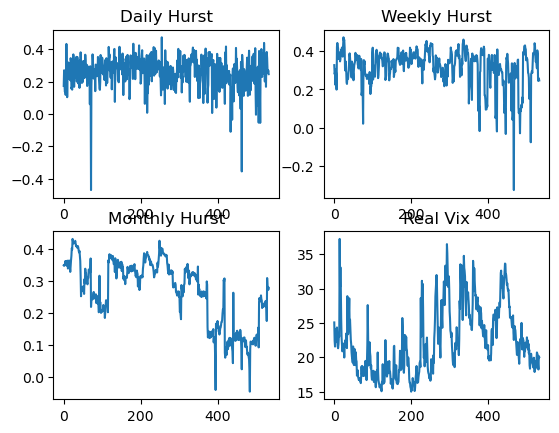

In [87]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 2)
  
# Prepare for the sub plots
axis[0, 0].plot(final_data['H_Daily'])
axis[0, 0].set_title('Daily Hurst')

axis[0, 1].plot(final_data['H_Weekly'])
axis[0, 1].set_title('Weekly Hurst')
  
axis[1, 0].plot(final_data['H_Monthly'])
axis[1, 0].set_title('Monthly Hurst')

axis[1, 1].plot(final_data['Real_VIX'])
axis[1, 1].set_title('Real Vix')

# Combine all the operations and display
plt.show()

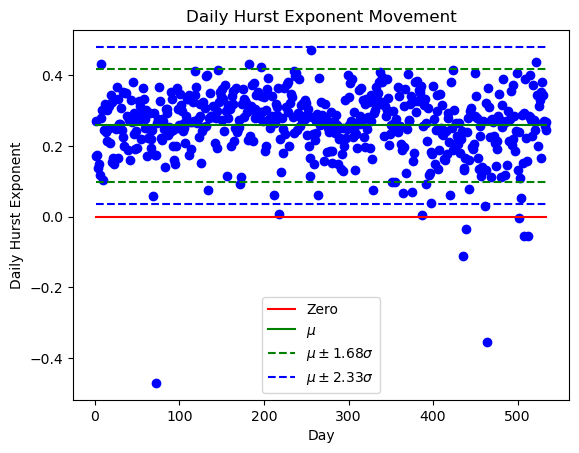

In [88]:
# Detect abnormal (negative) Hurst exponents
plot_x = np.arange(1, len(final_data)+1, 1)

plt.scatter(plot_x, final_data['H_Daily'], c='b')
plt.plot(plot_x, [0]*len(plot_x), c='r', label='Zero')
plt.plot(plot_x, [final_data['H_Daily'].mean()]*len(plot_x), c='g', label=r'$\mu$')

plt.plot(plot_x, [(final_data['H_Daily'].mean() + final_data['H_Daily'].std()*1.68)]*len(plot_x), c='g', linestyle='dashed', label=r'$\mu\pm1.68\sigma$')
plt.plot(plot_x, [(final_data['H_Daily'].mean() - final_data['H_Daily'].std()*1.68)]*len(plot_x), c='g', linestyle='dashed')

plt.plot(plot_x, [(final_data['H_Daily'].mean() + final_data['H_Daily'].std()*2.33)]*len(plot_x), c='b', linestyle='dashed', label=r'$\mu\pm2.33\sigma$')
plt.plot(plot_x, [(final_data['H_Daily'].mean() - final_data['H_Daily'].std()*2.33)]*len(plot_x), c='b', linestyle='dashed')
plt.title('Daily Hurst Exponent Movement')
plt.xlabel('Day')
plt.ylabel('Daily Hurst Exponent')
plt.legend()
plt.show()

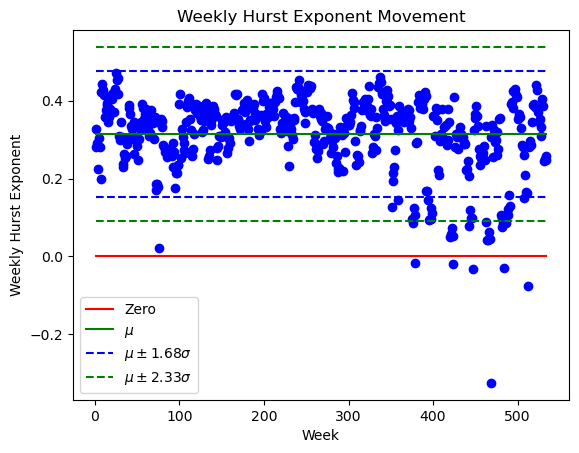

In [89]:
plt.scatter(plot_x, final_data['H_Weekly'], c='b')
plt.plot(plot_x, [0]*len(final_data), c='r', label='Zero')
plt.plot(plot_x, [final_data['H_Weekly'].mean()]*len(final_data), c='g', label=r'$\mu$')

plt.plot(plot_x, [(final_data['H_Weekly'].mean() + final_data['H_Weekly'].std()*1.68)]*len(final_data), c='b', linestyle='dashed', label=r'$\mu\pm1.68\sigma$')
plt.plot(plot_x, [(final_data['H_Weekly'].mean() - final_data['H_Weekly'].std()*1.68)]*len(final_data), c='b', linestyle='dashed')


plt.plot(plot_x, [(final_data['H_Weekly'].mean() + final_data['H_Weekly'].std()*2.33)]*len(final_data), c='g', linestyle='dashed', label=r'$\mu\pm2.33\sigma$')
plt.plot(plot_x, [(final_data['H_Weekly'].mean() - final_data['H_Weekly'].std()*2.33)]*len(final_data), c='g', linestyle='dashed')
plt.title('Weekly Hurst Exponent Movement')
plt.xlabel('Week')
plt.ylabel('Weekly Hurst Exponent')
plt.legend()

plt.show()

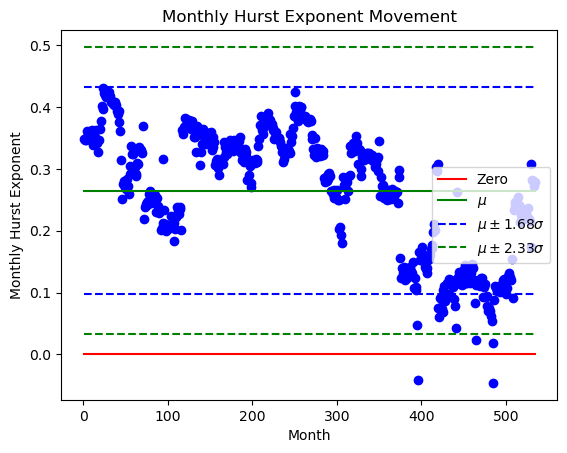

In [90]:
plt.scatter(plot_x, final_data['H_Monthly'], c='b')
plt.plot(plot_x, [0]*len(final_data), c='r', label='Zero')
plt.plot(plot_x, [final_data['H_Monthly'].mean()]*len(final_data), c='g', label=r'$\mu$')

plt.plot(plot_x, [(final_data['H_Monthly'].mean() + final_data['H_Monthly'].std()*1.68)]*len(final_data), c='b', linestyle='dashed', label=r'$\mu\pm1.68\sigma$')
plt.plot(plot_x, [(final_data['H_Monthly'].mean() - final_data['H_Monthly'].std()*1.68)]*len(final_data), c='b', linestyle='dashed')


plt.plot(plot_x, [(final_data['H_Monthly'].mean() + final_data['H_Monthly'].std()*2.33)]*len(final_data), c='g', linestyle='dashed', label=r'$\mu\pm2.33\sigma$')
plt.plot(plot_x, [(final_data['H_Monthly'].mean() - final_data['H_Monthly'].std()*2.33)]*len(final_data), c='g', linestyle='dashed')
plt.title('Monthly Hurst Exponent Movement')
plt.xlabel('Month')
plt.ylabel('Monthly Hurst Exponent')
plt.legend()

plt.show()

Locate the negative Hurst exponent(s) and fix it (or not)

In [91]:
negative_final = final_data.copy()
negative_index_Daily = negative_final[negative_final['H_Daily'] < 0].index
negative_index_Daily

Index([71, 434, 438, 463, 500, 507, 511], dtype='int64')

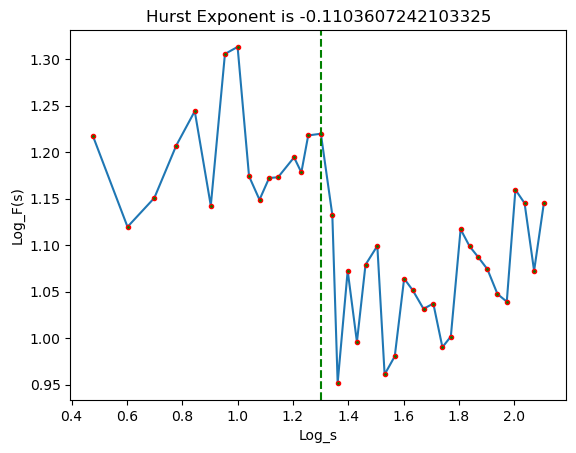

In [136]:
# Review the negative Hurst exponent process
n_sample = avg_daily
scales = np.unique(np.logspace(np.log10(3), np.log10((n_sample+1)/10), 50).astype(int))
F_summary_daily = pd.read_csv('Daily F Summary_08232023.csv', index_col=0)

# Log-log plot and calculate H
log10_lag = np.log10(scales)
log10_F = np.log10(np.array(F_summary_daily['q_2.0_434']).astype(float)) 
hurst_hat = np.polyfit(log10_lag, log10_F, 1)[0]

plt.plot(log10_lag, log10_F, marker="o", markersize=3, markeredgecolor="red", markerfacecolor="green")
plt.axvline(x = np.log10(scales[15]), color = 'g', linestyle='dashed') # Draw the line to seperate uptrend and downtrend
plt.xlabel('Log_s')
plt.ylabel('Log_F(s)')
plt.title(f'Hurst Exponent is {hurst_hat}')
plt.show()

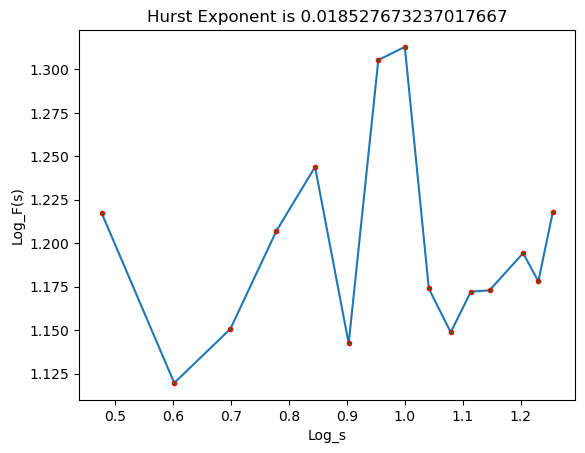

In [138]:
log10_lag = np.log10(scales)[:15]
log10_F = np.log10(np.array(F_summary_daily['q_2.0_434'][:15]).astype(float)) 
hurst_hat = np.polyfit(log10_lag, log10_F, 1)[0]

plt.plot(log10_lag, log10_F, marker="o", markersize=3, markeredgecolor="red", markerfacecolor="green")
plt.xlabel('Log_s')
plt.ylabel('Log_F(s)')
plt.title(f'Hurst Exponent is {hurst_hat}')
plt.show()

We'll continue the study on the original data and work on removing the abnormal ones later

# EDA of The Findings

## Analyze the absolute numbers

### Relationship between Hurst Exponents and VIX Index

#### OLS Regression

In [139]:
final_data = pd.read_csv('Final Data_vix_08232023.csv', index_col=0)
len(final_data)

534

In [178]:
# Add columns of returns
final_data['Return_H_Daily'] = np.log(final_data['H_Daily']).diff()
final_data['Return_H_Weekly'] = np.log(final_data['H_Weekly']).diff()
final_data['Return_H_Monthly'] = np.log(final_data['H_Monthly']).diff()
final_data['Return_VIX'] = np.log(final_data['Real_VIX']).diff()
final_data['Cum_Return_VIX'] = final_data['Return_VIX'].cumsum()

# Add a column of next day's VIX
final_data['Target_VIX'] = final_data['Real_VIX'].shift(-1)
final_data['Target_H_Daily'] = final_data['H_Daily'].shift(-1)

# Drop NAN rows
final_data.dropna(inplace=True)

# Save temp result
final_data.to_csv('final_data_Jan2020-Feb2023_returns_08232023.csv')

len(final_data)
final_data

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,H_Daily,H_Weekly,H_Monthly,Real_VIX,Return_H_Daily,Return_H_Weekly,Return_H_Monthly,Return_VIX,Cum_Return_VIX,Target_VIX,Target_H_Daily
1,0.269646,0.279924,0.346547,22.370001,0.444806,-0.154693,-0.004443,-0.113951,-0.113951,21.559999,0.175248
2,0.175248,0.290124,0.347401,21.559999,-0.430906,0.035793,0.002461,-0.036881,-0.150832,24.080000,0.137358
3,0.137358,0.223790,0.350418,24.080000,-0.243612,-0.259600,0.008648,0.110542,-0.040290,23.330000,0.150489
4,0.150489,0.303445,0.361072,23.330000,0.091300,0.304491,0.029950,-0.031642,-0.071932,22.209999,0.117353
5,0.117353,0.280880,0.354603,22.209999,-0.248703,-0.077273,-0.018077,-0.049197,-0.121129,23.250000,0.279406
...,...,...,...,...,...,...,...,...,...,...,...
528,0.382632,0.403617,0.174288,20.530001,0.077322,0.262880,-0.212045,-0.008729,-0.199785,20.340000,0.344718
529,0.344718,0.386262,0.308436,20.340000,-0.104348,-0.043950,0.570806,-0.009298,-0.209083,18.910000,0.270444
530,0.270444,0.245553,0.281836,18.910000,-0.242662,-0.453005,-0.090187,-0.072899,-0.281981,18.230000,0.255555
531,0.255555,0.251411,0.280836,18.230000,-0.056628,0.023579,-0.003556,-0.036622,-0.318603,20.170000,0.268662


In [141]:
original_ols = final_data.copy()

original_Y_ols = original_ols['Target_VIX']
original_X_ols = original_ols[['H_Daily', 'H_Weekly', 'H_Monthly']]
original_X_ols = sm.add_constant(original_X_ols)
original_model_ols = sm.OLS(original_Y_ols, original_X_ols)
original_results_ols = original_model_ols.fit()

print(original_results_ols.summary())

                            OLS Regression Results                            
Dep. Variable:             Target_VIX   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     7.959
Date:                Fri, 25 Aug 2023   Prob (F-statistic):           3.41e-05
Time:                        14:13:02   Log-Likelihood:                -1502.1
No. Observations:                 505   AIC:                             3012.
Df Residuals:                     501   BIC:                             3029.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.7722      1.028     26.031      0.0

In [179]:
# Predict VIX return based on Hurst expononents
original_Y_ols_1 = original_ols['Return_VIX']
original_X_ols_1 = original_ols[['H_Daily', 'H_Weekly', 'H_Monthly']]
original_X_ols_1 = sm.add_constant(original_X_ols_1)
original_model_ols_1 = sm.OLS(original_Y_ols_1, original_X_ols_1)
original_results_ols_1 = original_model_ols_1.fit()

print(original_results_ols_1.summary())

                            OLS Regression Results                            
Dep. Variable:             Return_VIX   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.7684
Date:                Fri, 25 Aug 2023   Prob (F-statistic):              0.512
Time:                        15:25:57   Log-Likelihood:                 568.69
No. Observations:                 505   AIC:                            -1129.
Df Residuals:                     501   BIC:                            -1112.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0047      0.017     -0.278      0.7

#### Predict the Movement Direction of VIX

Support Vector Machine (SVM)

In [196]:
direction_vix_svm = pd.read_csv('Final Data_vix_08232023.csv', index_col=0)
direction_vix_svm['Return_VIX'] = np.log(direction_vix_svm['Real_VIX']).diff()
direction_vix_svm.dropna(inplace=True)
direction_vix_svm

,H_Daily,H_Weekly,H_Monthly,Real_VIX,Return_VIX
1,0.269646,0.279924,0.346547,22.370001,-0.113951
2,0.175248,0.290124,0.347401,21.559999,-0.036881
3,0.137358,0.223790,0.350418,24.080000,0.110542
4,0.150489,0.303445,0.361072,23.330000,-0.031642
5,0.117353,0.280880,0.354603,22.209999,-0.049197
...,...,...,...,...,...
529,0.344718,0.386262,0.308436,20.340000,-0.009298
530,0.270444,0.245553,0.281836,18.910000,-0.072899
531,0.255555,0.251411,0.280836,18.230000,-0.036622
532,0.268662,0.258108,0.271596,20.170000,0.101128


In [197]:
# Store all predictor variables in a variable X
X = direction_vix_svm[['H_Daily', 'H_Weekly', 'H_Monthly']]

# Definining the target variables
y = np.where(direction_vix_svm['Real_VIX'].shift(-1) > direction_vix_svm['Real_VIX'], 1, 0)

for random_state in range(41,42):
    # Data splitting into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    # Perform the SVM
    cls = SVC().fit(X_train, y_train)
#     cls = SVC(kernel='linear', C=1).fit(X_train, y_train)

    # Preedict code
    direction_vix_svm['Predicted_Signal'] = cls.predict(X)

    
    print('-' * 5)
    # Show the score
    print(f'The in-sample score is {cls.score(X_train, y_train)}')
    print(f'The out-of-sample score is {cls.score(X_test, y_test)}')

    # Cross validation
    scores = cross_val_score(cls, X, y, cv=6)
    print(f'The cross validation scores are {scores}')

    
    print(f'random state is {random_state}')
    print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

-----
The in-sample score is 0.5821596244131455
The out-of-sample score is 0.6355140186915887
The cross validation scores are [0.51685393 0.5505618  0.58426966 0.56179775 0.56179775 0.57954545]
random state is 41
0.56 accuracy with a standard deviation of 0.02


Scale the datasets, then perform the SVM again

In [145]:
scaling_minmax = MinMaxScaler()
scaled_direction_vix_svm = pd.DataFrame()
scaled_direction_vix_svm['H_Daily'] = final_data['H_Daily']
scaled_direction_vix_svm['H_Weekly'] = final_data['H_Weekly']
scaled_direction_vix_svm['H_Monthly'] = final_data['H_Monthly']
scaled_direction_vix_svm['Real_VIX'] = final_data['Real_VIX']
scaled_direction_vix_svm = scaling_minmax.fit_transform(scaled_direction_vix_svm)
scaled_direction_vix_svm = pd.DataFrame(scaled_direction_vix_svm, 
                                        columns=['H_Daily', 'H_Weekly', 
                                                 'H_Monthly', 'Real_VIX'])
scaled_direction_vix_svm

,H_Daily,H_Weekly,H_Monthly,Real_VIX
0,0.564628,0.574026,0.783214,0.331532
1,0.362860,0.596668,0.785415,0.295045
2,0.281872,0.449432,0.793193,0.408559
3,0.309939,0.626234,0.820654,0.374775
4,0.239113,0.576149,0.803981,0.324324
...,...,...,...,...
500,0.806128,0.848577,0.339195,0.248649
501,0.725088,0.810056,0.684978,0.240090
502,0.566333,0.497736,0.616415,0.175676
503,0.534508,0.510740,0.613836,0.145045


In [146]:
# Store all predictor variables in a variable X
X = scaled_direction_vix_svm[['H_Daily', 'H_Weekly', 'H_Monthly']]

# Definining the target variables
y = np.where(scaled_direction_vix_svm['Real_VIX'].shift(-1) > scaled_direction_vix_svm['Real_VIX'], 1, 0)

# Data splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

# Perform the SVM
cls = SVC(kernel='linear', C=1).fit(X_train, y_train)
# cls = SVC(kernel='linear', C=1).fit(X_train, y_train)

# Show the score
print(f'The in-sample score is {cls.score(X_train, y_train)}')
print(f'The out-of-sample score is {cls.score(X_test, y_test)}')

# Cross validation
scores = cross_val_score(cls, X, y, cv=6)
print(f'The cross validation scores are {scores}')

print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

The in-sample score is 0.5742574257425742
The out-of-sample score is 0.5643564356435643
The cross validation scores are [0.57647059 0.57142857 0.57142857 0.57142857 0.57142857 0.57142857]
0.57 accuracy with a standard deviation of 0.00


The scaling above shows that it didn't improve the prediction ability

Visualize the SVM Prediction

In [198]:
direction_vix_svm

,H_Daily,H_Weekly,H_Monthly,Real_VIX,Return_VIX,Predicted_Signal
1,0.269646,0.279924,0.346547,22.370001,-0.113951,0
2,0.175248,0.290124,0.347401,21.559999,-0.036881,0
3,0.137358,0.223790,0.350418,24.080000,0.110542,0
4,0.150489,0.303445,0.361072,23.330000,-0.031642,0
5,0.117353,0.280880,0.354603,22.209999,-0.049197,0
...,...,...,...,...,...,...
529,0.344718,0.386262,0.308436,20.340000,-0.009298,0
530,0.270444,0.245553,0.281836,18.910000,-0.072899,0
531,0.255555,0.251411,0.280836,18.230000,-0.036622,0
532,0.268662,0.258108,0.271596,20.170000,0.101128,0


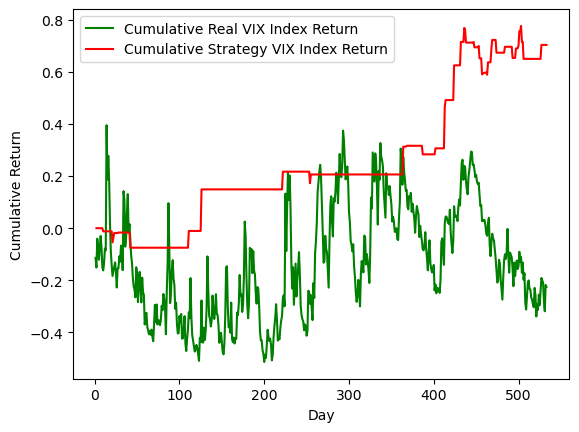

In [199]:
# Calculate strategy returns
direction_vix_svm['Strategy_Return'] = direction_vix_svm['Return_VIX'] * direction_vix_svm['Predicted_Signal'].shift(1)

# Calculate Cumulutive returns
direction_vix_svm['Cum_VIX_Ret'] = direction_vix_svm['Return_VIX'].cumsum()
direction_vix_svm['Cum_Strategy'] = direction_vix_svm['Strategy_Return'].cumsum()

# Plot Strategy Returns vs Original Returns
plt.plot(direction_vix_svm['Cum_VIX_Ret'], color='green', label='Cumulative Real VIX Index Return')
plt.plot(direction_vix_svm['Cum_Strategy'], color='red', label='Cumulative Strategy VIX Index Return')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Cumulative Return')
plt.show()

### Predict the Hurst Exponent

#### OLS Regression

In [149]:
final_data = pd.read_csv('final_data_Jan2020-Feb2023_returns_08232023.csv')

# Create a new dataframe to analyze relationships between Hurst exponents at different time spots
H_est = pd.DataFrame()
H_est['H_Daily'] = final_data['H_Daily'].copy()
H_est['H_Weekly'] = final_data['H_Weekly'].copy()
H_est['H_Monthly'] = final_data['H_Monthly'].copy()
H_est['Target_H_Daily'] = final_data['Target_H_Daily']
H_est.dropna(inplace=True)

H_est

,H_Daily,H_Weekly,H_Monthly,Target_H_Daily
0,0.269646,0.279924,0.346547,0.175248
1,0.175248,0.290124,0.347401,0.137358
2,0.137358,0.223790,0.350418,0.150489
3,0.150489,0.303445,0.361072,0.117353
4,0.117353,0.280880,0.354603,0.279406
...,...,...,...,...
500,0.382632,0.403617,0.174288,0.344718
501,0.344718,0.386262,0.308436,0.270444
502,0.270444,0.245553,0.281836,0.255555
503,0.255555,0.251411,0.280836,0.268662


In [150]:
H_est_ols = H_est.copy()

H_est_Y_ols = H_est_ols['Target_H_Daily']
H_est_X_ols = H_est_ols[['H_Daily', 'H_Weekly', 'H_Monthly']]
H_est_X_ols = sm.add_constant(H_est_X_ols)
H_est_model_ols = sm.OLS(H_est_Y_ols, H_est_X_ols)
H_est_results_ols = H_est_model_ols.fit()

print(H_est_results_ols.summary())

                            OLS Regression Results                            
Dep. Variable:         Target_H_Daily   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     9.057
Date:                Fri, 25 Aug 2023   Prob (F-statistic):           7.54e-06
Time:                        14:13:02   Log-Likelihood:                 483.36
No. Observations:                 505   AIC:                            -958.7
Df Residuals:                     501   BIC:                            -941.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1817      0.020      9.009      0.0

## Analyze the returns

In [200]:
final_data = pd.read_csv('final_data_Jan2020-Feb2023_returns_08232023.csv')

final_data_diff = pd.DataFrame()

final_data_diff['delta_H_D'] = final_data['Return_H_Daily']
final_data_diff['delta_H_W'] = final_data['Return_H_Weekly']
final_data_diff['delta_H_M'] = final_data['Return_H_Monthly']
final_data_diff['delta_Real_V'] = final_data['Return_VIX']
final_data_diff.dropna(inplace=True)
final_data_diff

,delta_H_D,delta_H_W,delta_H_M,delta_Real_V
0,0.444806,-0.154693,-0.004443,-0.113951
1,-0.430906,0.035793,0.002461,-0.036881
2,-0.243612,-0.259600,0.008648,0.110542
3,0.091300,0.304491,0.029950,-0.031642
4,-0.248703,-0.077273,-0.018077,-0.049197
...,...,...,...,...
500,0.077322,0.262880,-0.212045,-0.008729
501,-0.104348,-0.043950,0.570806,-0.009298
502,-0.242662,-0.453005,-0.090187,-0.072899
503,-0.056628,0.023579,-0.003556,-0.036622


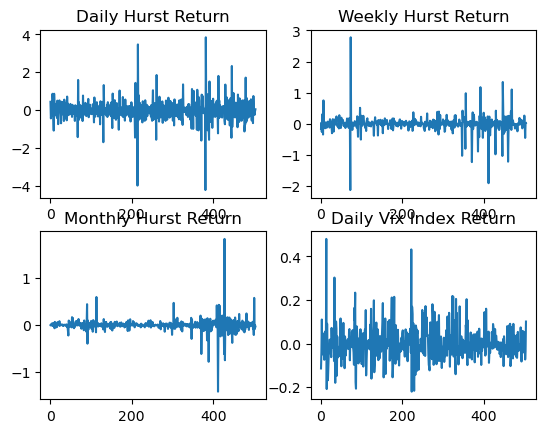

In [201]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 2)
  
# For Sine Function
axis[0, 0].plot(final_data_diff['delta_H_D'])
axis[0, 0].set_title('Daily Hurst Return')
  
# For Cosine Function
axis[0, 1].plot(final_data_diff['delta_H_W'])
axis[0, 1].set_title('Weekly Hurst Return')
  
# For Tangent Function
axis[1, 0].plot(final_data_diff['delta_H_M'])
axis[1, 0].set_title('Monthly Hurst Return')
  
# For Tanh Function
axis[1, 1].plot(final_data_diff['delta_Real_V'])
axis[1, 1].set_title('Daily Vix Index Return')
  
# Combine all the operations and display
plt.show()

In [202]:
pct_vix_svm = final_data_diff.copy()

# Store all predictor variables in a variable X
X = pct_vix_svm[['delta_H_D', 'delta_H_W', 'delta_H_M']]

# Definining the target variables
y = np.where(pct_vix_svm['delta_Real_V'].shift(-1) > pct_vix_svm['delta_Real_V'], 1, 0)

for random_state in range(50):
    print('-'*5)
    print(f'random state is {random_state}')
    
    # Data splitting into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=14)

    # Perform the SVM
    cls = SVC().fit(X_train, y_train)
#     cls = SVC(kernel='linear', C=1).fit(X_train, y_train)
    print(f'The in-sample score is {cls.score(X_train, y_train)}')
    print(f'The out-of-sample score is {cls.score(X_test, y_test)}')

    # Cross validation
    scores = cross_val_score(cls, X, y, cv=6)
    print(f'The cross validation scores are {scores}')

    print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

-----
random state is 0
The in-sample score is 0.5767326732673267
The out-of-sample score is 0.5742574257425742
The cross validation scores are [0.41176471 0.47619048 0.55952381 0.47619048 0.42857143 0.55952381]
0.49 accuracy with a standard deviation of 0.06
-----
random state is 1
The in-sample score is 0.5767326732673267
The out-of-sample score is 0.5742574257425742
The cross validation scores are [0.41176471 0.47619048 0.55952381 0.47619048 0.42857143 0.55952381]
0.49 accuracy with a standard deviation of 0.06
-----
random state is 2
The in-sample score is 0.5767326732673267
The out-of-sample score is 0.5742574257425742
The cross validation scores are [0.41176471 0.47619048 0.55952381 0.47619048 0.42857143 0.55952381]
0.49 accuracy with a standard deviation of 0.06
-----
random state is 3
The in-sample score is 0.5767326732673267
The out-of-sample score is 0.5742574257425742
The cross validation scores are [0.41176471 0.47619048 0.55952381 0.47619048 0.42857143 0.55952381]
0.49 acc

The cross validation scores are [0.41176471 0.47619048 0.55952381 0.47619048 0.42857143 0.55952381]
0.49 accuracy with a standard deviation of 0.06
-----
random state is 32
The in-sample score is 0.5767326732673267
The out-of-sample score is 0.5742574257425742
The cross validation scores are [0.41176471 0.47619048 0.55952381 0.47619048 0.42857143 0.55952381]
0.49 accuracy with a standard deviation of 0.06
-----
random state is 33
The in-sample score is 0.5767326732673267
The out-of-sample score is 0.5742574257425742
The cross validation scores are [0.41176471 0.47619048 0.55952381 0.47619048 0.42857143 0.55952381]
0.49 accuracy with a standard deviation of 0.06
-----
random state is 34
The in-sample score is 0.5767326732673267
The out-of-sample score is 0.5742574257425742
The cross validation scores are [0.41176471 0.47619048 0.55952381 0.47619048 0.42857143 0.55952381]
0.49 accuracy with a standard deviation of 0.06
-----
random state is 35
The in-sample score is 0.5767326732673267
Th

In [203]:
# Predict the signals
pct_vix_svm['Predicted_Signal'] = cls.predict(X)

# Calculate daily returns
pct_vix_svm['VIX_Return'] = pct_vix_svm['delta_Real_V']

# Calculate strategy returns
pct_vix_svm['Strategy_Return'] = pct_vix_svm['VIX_Return'] * pct_vix_svm['Predicted_Signal'].shift(1)

# Calculate Cumulutive returns
pct_vix_svm['Cum_VIX_Ret'] = pct_vix_svm['VIX_Return'].cumsum()
pct_vix_svm['Cum_Strategy'] = pct_vix_svm['Strategy_Return'].cumsum()

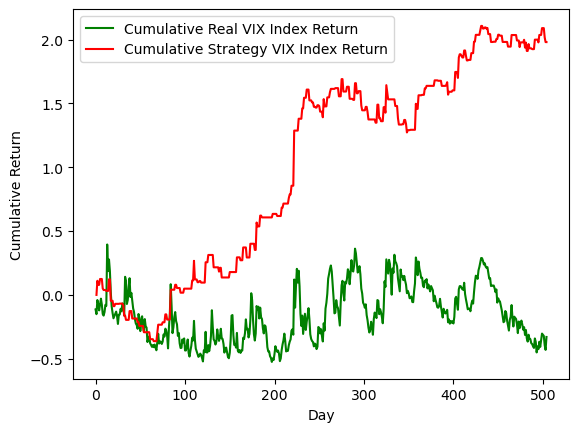

In [204]:
# Plot Strategy Returns vs Original Returns
plt.plot(pct_vix_svm['Cum_VIX_Ret'], color='green', label='Cumulative Real VIX Index Return')
plt.plot(pct_vix_svm['Cum_Strategy'], color='red', label='Cumulative Strategy VIX Index Return')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Cumulative Return')
plt.show()

Filter out the extreme values ($2.33\sigma$ away from $\mu$)

In [205]:
# Remove those over pct change data points three standard deviation away from mean
# A general function to remove the outliers by ZSCORE method
def remove_outliers(df, col, threshold=2.33):
    z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
    filtered_df = df[(z_scores < threshold).all(axis=1)]
    return filtered_df

filtered_final_diff = remove_outliers(final_data_diff[1:], ['delta_H_D', 'delta_H_W', 'delta_H_M', 'delta_Real_V'])
filtered_final_diff

,delta_H_D,delta_H_W,delta_H_M,delta_Real_V
1,-0.430906,0.035793,0.002461,-0.036881
2,-0.243612,-0.259600,0.008648,0.110542
3,0.091300,0.304491,0.029950,-0.031642
4,-0.248703,-0.077273,-0.018077,-0.049197
5,0.867476,-0.344246,-0.016353,0.045763
...,...,...,...,...
499,0.748746,-0.066111,-0.014458,0.053558
500,0.077322,0.262880,-0.212045,-0.008729
502,-0.242662,-0.453005,-0.090187,-0.072899
503,-0.056628,0.023579,-0.003556,-0.036622


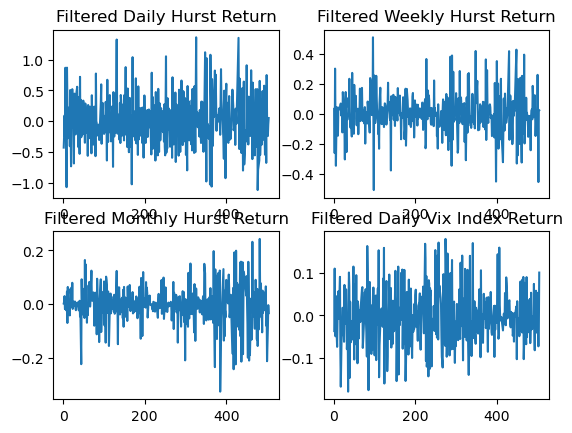

In [206]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 2)
  
# For Sine Function
axis[0, 0].plot(filtered_final_diff['delta_H_D'])
axis[0, 0].set_title('Filtered Daily Hurst Return')
  
# For Cosine Function
axis[0, 1].plot(filtered_final_diff['delta_H_W'])
axis[0, 1].set_title('Filtered Weekly Hurst Return')
  
# For Tangent Function
axis[1, 0].plot(filtered_final_diff['delta_H_M'])
axis[1, 0].set_title('Filtered Monthly Hurst Return')
  
# For Tanh Function
axis[1, 1].plot(filtered_final_diff['delta_Real_V'])
axis[1, 1].set_title('Filtered Daily Vix Index Return')
  
# Combine all the operations and display
plt.show()

### Predict VIX Movement

Filtered data OLS regression

In [158]:
filtered_ols = filtered_final_diff.copy()

filtered_Y_ols = filtered_ols['delta_Real_V']
filtered_X_ols = filtered_ols[['delta_H_D', 'delta_H_W', 'delta_H_M']]
filtered_X_ols = sm.add_constant(filtered_X_ols)
filtered_model_ols = sm.OLS(filtered_Y_ols, filtered_X_ols)
filtered_results_ols = filtered_model_ols.fit()

print(filtered_results_ols.summary())

                            OLS Regression Results                            
Dep. Variable:           delta_Real_V   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.4885
Date:                Fri, 25 Aug 2023   Prob (F-statistic):              0.690
Time:                        14:13:03   Log-Likelihood:                 584.53
No. Observations:                 447   AIC:                            -1161.
Df Residuals:                     443   BIC:                            -1145.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0050      0.003     -1.619      0.1

SVM

In [207]:
pct_vix_svm = filtered_final_diff.copy()

# Store all predictor variables in a variable X
X = pct_vix_svm[['delta_H_D', 'delta_H_W', 'delta_H_M']]

# Definining the target variables
y = np.where(pct_vix_svm['delta_Real_V'].shift(-1) > pct_vix_svm['delta_Real_V'], 1, 0)

# Data splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

# Perform the SVM
cls = SVC().fit(X_train, y_train)
# cls = SVC(kernel='linear', C=1).fit(X_train, y_train)
print(f'The in-sample score is {cls.score(X_train, y_train)}')
print(f'The out-of-sample score is {cls.score(X_test, y_test)}')

# Cross validation
scores = cross_val_score(cls, X, y, cv=6)
print(f'The cross validation scores are {scores}')

print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

The in-sample score is 0.5658263305322129
The out-of-sample score is 0.4777777777777778
The cross validation scores are [0.46666667 0.48       0.50666667 0.44594595 0.39189189 0.48648649]
0.46 accuracy with a standard deviation of 0.04


Visualize

In [208]:
# Predict the signals
pct_vix_svm['Predicted_Signal'] = cls.predict(X)

# Calculate daily returns
pct_vix_svm['VIX_Return'] = pct_vix_svm['delta_Real_V']

# Calculate strategy returns
pct_vix_svm['Strategy_Return'] = pct_vix_svm['VIX_Return'] * pct_vix_svm['Predicted_Signal'].shift(1)

# Calculate Cumulutive returns
pct_vix_svm['Cum_VIX_Ret'] = pct_vix_svm['VIX_Return'].cumsum()
pct_vix_svm['Cum_Strategy'] = pct_vix_svm['Strategy_Return'].cumsum()

In [161]:
pct_vix_svm

,delta_H_D,delta_H_W,delta_H_M,delta_Real_V,Predicted_Signal,VIX_Return,Strategy_Return,Cum_VIX_Ret,Cum_Strategy
1,-0.430906,0.035793,0.002461,-0.036881,1,-0.036881,NaN,-0.036881,NaN
2,-0.243612,-0.259600,0.008648,0.110542,1,0.110542,0.110542,0.073661,0.110542
3,0.091300,0.304491,0.029950,-0.031642,1,-0.031642,-0.031642,0.042019,0.078900
4,-0.248703,-0.077273,-0.018077,-0.049197,1,-0.049197,-0.049197,-0.007178,0.029703
5,0.867476,-0.344246,-0.016353,0.045763,0,0.045763,0.045763,0.038584,0.075465
...,...,...,...,...,...,...,...,...,...
499,0.748746,-0.066111,-0.014458,0.053558,0,0.053558,0.053558,-2.183504,0.333212
500,0.077322,0.262880,-0.212045,-0.008729,0,-0.008729,-0.000000,-2.192233,0.333212
502,-0.242662,-0.453005,-0.090187,-0.072899,0,-0.072899,-0.000000,-2.265132,0.333212
503,-0.056628,0.023579,-0.003556,-0.036622,1,-0.036622,-0.000000,-2.301754,0.333212


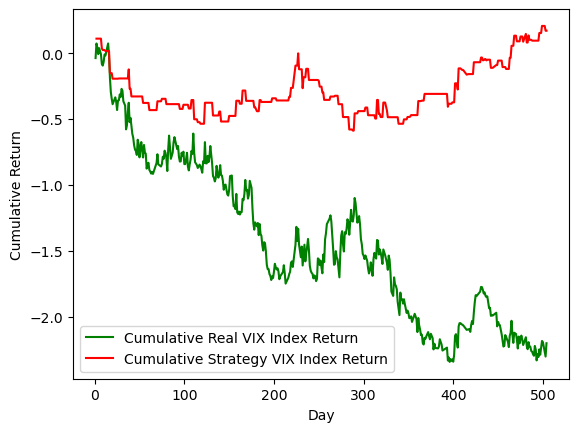

In [209]:
# Plot Strategy Returns vs Original Returns
plt.plot(pct_vix_svm['Cum_VIX_Ret'], color='green', label='Cumulative Real VIX Index Return')
plt.plot(pct_vix_svm['Cum_Strategy'], color='red', label='Cumulative Strategy VIX Index Return')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Cumulative Return')
plt.show()

Adjust the moving average

In [163]:
final_data = pd.read_csv('Final Data_vix_08232023.csv', index_col=0)
final_data

,H_Daily,H_Weekly,H_Monthly,Real_VIX
0,0.172829,0.326754,0.348090,25.070000
1,0.269646,0.279924,0.346547,22.370001
2,0.175248,0.290124,0.347401,21.559999
3,0.137358,0.223790,0.350418,24.080000
4,0.150489,0.303445,0.361072,23.330000
...,...,...,...,...
529,0.344718,0.386262,0.308436,20.340000
530,0.270444,0.245553,0.281836,18.910000
531,0.255555,0.251411,0.280836,18.230000
532,0.268662,0.258108,0.271596,20.170000


In [164]:
# Create a new dataframe to analyze relationships between Hurst exponents at different time spots

H_est = pd.DataFrame()
H_est['T_H_Daily'] = final_data['H_Daily'].copy()
H_est['T_H_Weekly'] = final_data['H_Weekly'].copy()
H_est['T_H_Monthly'] = final_data['H_Monthly'].copy()
H_est['T_Real_VIX'] = final_data['Real_VIX'].copy()
H_est['T-1_H_Daily'] = H_est['T_H_Daily'].shift(1)
H_est['T-5_H_Weekly'] = H_est['T_H_Weekly'].shift(5)
H_est['T-22_H_Monthly'] = H_est['T_H_Monthly'].shift(22)
H_est.dropna(inplace=True)

H_est

,T_H_Daily,T_H_Weekly,T_H_Monthly,T_Real_VIX,T-1_H_Daily,T-5_H_Weekly,T-22_H_Monthly
22,0.149826,0.371162,0.397744,21.240000,0.165393,0.379458,0.348090
23,0.251836,0.430171,0.430650,21.629999,0.149826,0.407495,0.346547
24,0.247544,0.471838,0.423142,21.990000,0.251836,0.403976,0.347401
25,0.367808,0.453611,0.419167,21.250000,0.247544,0.418316,0.350418
26,0.333334,0.459511,0.416371,19.969999,0.367808,0.419098,0.361072
...,...,...,...,...,...,...,...
529,0.344718,0.386262,0.308436,20.340000,0.382632,0.344334,0.091875
530,0.270444,0.245553,0.281836,18.910000,0.344718,0.352731,0.234179
531,0.255555,0.251411,0.280836,18.230000,0.270444,0.331523,0.246183
532,0.268662,0.258108,0.271596,20.170000,0.255555,0.310315,0.241241


In [165]:
H_est_ols = H_est.copy()
# H_est_ols
H_est_Y_ols = H_est_ols['T_Real_VIX']
H_est_X_ols = H_est_ols[['T-1_H_Daily', 'T-5_H_Weekly', 'T-22_H_Monthly']]
H_est_X_ols = sm.add_constant(H_est_X_ols)
H_est_model_ols = sm.OLS(H_est_Y_ols, H_est_X_ols)
H_est_results_ols = H_est_model_ols.fit()

print(H_est_results_ols.summary())

                            OLS Regression Results                            
Dep. Variable:             T_Real_VIX   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     6.661
Date:                Fri, 25 Aug 2023   Prob (F-statistic):           0.000204
Time:                        14:13:03   Log-Likelihood:                -1523.8
No. Observations:                 512   AIC:                             3056.
Df Residuals:                     508   BIC:                             3072.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             26.3742      0.938     28.

In [166]:
H_est_svm = H_est.copy()

# Store all predictor variables in a variable X
X = H_est_svm[['T-1_H_Daily', 'T-5_H_Weekly', 'T-22_H_Monthly']]

# Definining the target variables
y = np.where(H_est_svm['T_Real_VIX'].shift(-1) > H_est_svm['T_Real_VIX'], 1, 0)

# Data splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

cls = SVC(kernel='linear', C=1).fit(X_train, y_train)

In [167]:
print(f'in-sample score is {cls.score(X_train, y_train)}')
print(f'out-of-sample score is {cls.score(X_test, y_test)}')

in-sample score is 0.5452322738386308
out-of-sample score is 0.6504854368932039


Cross validation

In [168]:
scores = cross_val_score(cls, X, y, cv=10)
print(f'cross validation scores are {scores}')

cross validation scores are [0.55769231 0.55769231 0.56862745 0.56862745 0.56862745 0.56862745
 0.56862745 0.56862745 0.56862745 0.56862745]


In [169]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.57 accuracy with a standard deviation of 0.00


Visualization

In [170]:
#Preedict code
H_est_svm['Predicted_Signal'] = cls.predict(X)

# Calculate daily returns
H_est_svm['VIX_Return'] = H_est_svm.T_Real_VIX.pct_change()

# Calculate strategy returns
H_est_svm['Strategy_Return'] = H_est_svm['VIX_Return'] * H_est_svm['Predicted_Signal'].shift(1)

# Calculate Cumulutive returns
H_est_svm['Cum_VIX_Ret'] = H_est_svm['VIX_Return'].cumsum()
H_est_svm['Cum_Strategy'] = H_est_svm['Strategy_Return'].cumsum()

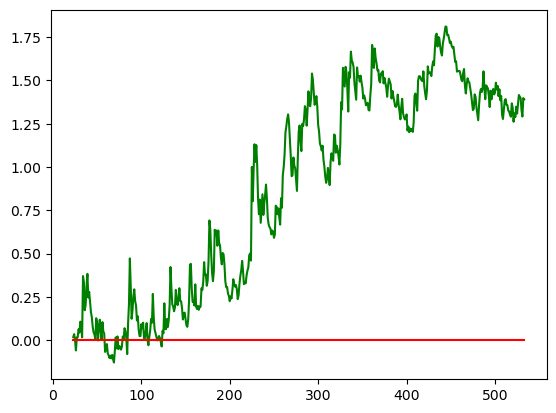

In [171]:
# Plot Strategy Returns vs Original Returns
plt.plot(H_est_svm['Cum_VIX_Ret'], color='green')
plt.plot(H_est_svm['Cum_Strategy'], color='red')

The above analyses show no apparent relationships between Hurst exponents and VIX index. Let's see if we can trade VIX based on Hurst exponent signals.

### Compared with History Volatility

In [172]:
df_temp = pd.read_csv('Final Data_vix_08232023.csv', index_col=0)
hv = pd.DataFrame()
hv['vix'] = df_temp['Real_VIX']
hv['vol_vix'] = (hv['vix'].rolling(22).std()) ** 2 * 252

hv['vol_1'] = hv['vol_vix'].shift(1)
hv['vol_5'] = hv['vol_vix'].shift(5)
hv['vol_22'] = hv['vol_vix'].shift(22)

hv['ret_vix'] = np.log(hv['vix']).diff()
hv['ret_vol_1'] = np.log(hv['vol_1']).diff()
hv['ret_vol_5'] = np.log(hv['vol_5']).diff()
hv['ret_vol_22'] = np.log(hv['vol_22']).diff()

hv.dropna(inplace=True)
hv

,vix,vol_vix,vol_1,vol_5,vol_22,ret_vix,ret_vol_1,ret_vol_5,ret_vol_22
44,21.910000,1598.708644,1630.441067,1715.067980,4658.167195,-0.029235,-0.043323,-0.133037,0.028204
45,20.690001,1652.452640,1598.708644,1675.058912,4701.864964,-0.057293,-0.019654,-0.023604,0.009337
46,20.030001,1768.470320,1652.452640,1730.019750,4674.223761,-0.032419,0.033064,0.032284,-0.005896
47,19.790001,1869.337659,1768.470320,1702.628581,4791.987769,-0.012054,0.067854,-0.015960,0.024882
48,19.230000,1935.913431,1869.337659,1630.441067,5002.311607,-0.028705,0.055469,-0.043323,0.042955
...,...,...,...,...,...,...,...,...,...
529,20.340000,168.073128,191.968130,368.538448,268.549307,-0.009298,-0.007159,-0.149009,0.030890
530,18.910000,167.108765,168.073128,282.686153,366.992933,-0.072899,-0.132930,-0.265208,0.312308
531,18.230000,170.223115,167.108765,250.940730,357.162965,-0.036622,-0.005754,-0.119121,-0.027150
532,20.170000,177.570553,170.223115,193.347291,390.449146,0.101128,0.018465,-0.260729,0.089106


In [173]:
hv_ols = hv.copy()
# H_est_ols
hv_Y_ols = hv['ret_vix']
hv_X_ols = hv_ols[['ret_vol_1', 'ret_vol_5', 'ret_vol_22']]
hv_X_ols = sm.add_constant(hv_X_ols)
hv_model_ols = sm.OLS(hv_Y_ols, hv_X_ols)
hv_results_ols = hv_model_ols.fit()

print(hv_results_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                ret_vix   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     2.293
Date:                Fri, 25 Aug 2023   Prob (F-statistic):             0.0772
Time:                        14:13:03   Log-Likelihood:                 588.15
No. Observations:                 490   AIC:                            -1168.
Df Residuals:                     486   BIC:                            -1152.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.003     -0.085      0.9

In [174]:
hv_svm = hv.copy()

# Store all predictor variables in a variable X
X = hv_svm[['ret_vol_1', 'ret_vol_5', 'ret_vol_22']]

# Definining the target variables
y = np.where(hv_svm['vix'].shift(-1) > hv_svm['vix'], 1, 0)

# Data splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

# Perform the SVM
cls = SVC(kernel='linear', C=1).fit(X_train, y_train)
print(f'The in-sample score is {cls.score(X_train, y_train)}')
print(f'The out-of-sample score is {cls.score(X_test, y_test)}')

# Cross validation
scores = cross_val_score(cls, X, y, cv=6)
print(f'The cross validation scores are {scores}')

print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

The in-sample score is 0.5841836734693877
The out-of-sample score is 0.5102040816326531
The cross validation scores are [0.57317073 0.57317073 0.57317073 0.56097561 0.56790123 0.56790123]
0.57 accuracy with a standard deviation of 0.00


In [175]:
# Predict the signals
hv_svm['Predicted_Signal'] = cls.predict(X)

# Calculate strategy returns
hv_svm['Strategy_Return'] = hv_svm['ret_vix'] * hv_svm['Predicted_Signal'].shift(1)

# Calculate Cumulutive returns
hv_svm['Cum_VIX_Ret'] = hv_svm['ret_vix'].cumsum()
hv_svm['Cum_Strategy'] = hv_svm['Strategy_Return'].cumsum()

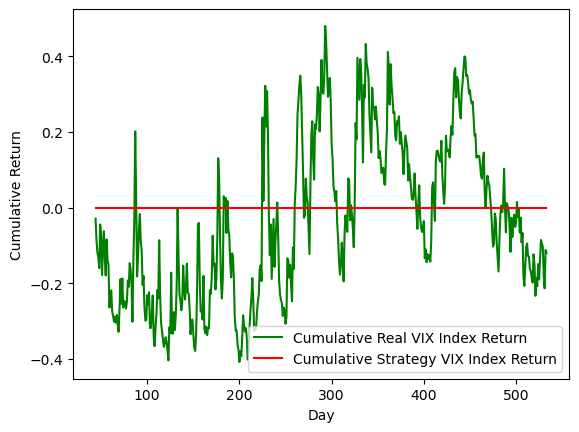

In [176]:
# Plot Strategy Returns vs Original Returns
plt.plot(hv_svm['Cum_VIX_Ret'], color='green', label='Cumulative Real VIX Index Return')
plt.plot(hv_svm['Cum_Strategy'], color='red', label='Cumulative Strategy VIX Index Return')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Cumulative Return')
plt.show()

# Future Study

The number of dataset on daily, weekly and monthly bases are not even due to (1) uncontinuous data (interval greater than one minute); (2) change of daylight saving time; (3) holidays of different countries and; (4) time zones (the date of of VIX index closing price is not always the same as GMT). Future study will (1) fill the missing data using systematic approaches, e.g., interpolation; (2) 

In [177]:
# Weekly data availability fluctuates
available_weekly.plot()

NameError: name 'available_weekly' is not defined

In [ ]:
# Daily data ability fluctuates
available_daily.groupby(['day_of_week']).plot()

In [ ]:
available_monthly.plot()